In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def peek(x, amp, mu, width):
    return amp*np.exp(-(x-mu)**2/np.log(16)/width**2)

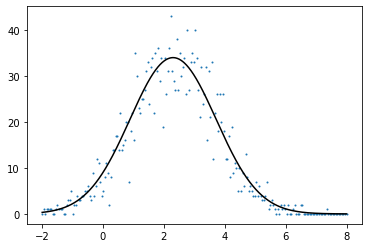

In [3]:
amp = 34
mu = 2.3
width = 1.2

X = np.linspace(-2,8,200)
f = peek(X, amp, mu, width)
Y = np.random.poisson(f)

lin = np.linspace(-2,8,1000)
plt.plot(lin, peek(lin, amp, mu, width), color='k')
plt.scatter(X, Y, s=1)

In [139]:
class MH_sampler_poisson(object):
    def __init__(self, X, Y, eps=(0.1, 0.1, 0.1), beta=1.0, random_state=None):
        self.eps = eps
        self.random_state = random_state
        self.random = np.random
        self.random.seed(random_state)
        self.X = X
        self.Y = Y
        self.beta = beta
        self.lgammas = sum(math.lgamma(y+1) for y in Y)
    
    def logLikelihood(self, a, m, w):
        if not(1e-2<a<1e4 and -20<m<20 and 1e-2<w<1e4):
            return -np.inf
        f = peek(self.X, a, m, w)
        return ((self.Y*np.log(f+1e-300)-f).sum()-self.lgammas) * self.beta

    def sampling(self, samplesize=10**4, init=(1, 1, 1)):
        pre_param = init
        samples = [pre_param]
        accepts = [False]
        pre_ll = self.logLikelihood(*pre_param)
        lls = [pre_ll]
        for i in range(1, samplesize):
            a,m,w = pre_param
            if i%3==0:
                la = np.log(a)
                la += self.random.normal(0, self.eps[0])
                a = np.exp(la)
            elif i%3==1:
                m += self.random.normal(0, self.eps[1])
            else:
                lw = np.log(w)
                lw += self.random.normal(0, self.eps[2])
                w = np.exp(lw)
            new_ll = self.logLikelihood(a, m, w)
            #print(a,m,w,new_ll)
            if new_ll>=pre_ll or self.random.rand() <= np.exp(-pre_ll+new_ll):
                accepts += [True]
                pre_param = (a, m, w)
                pre_ll = new_ll
            else:
                accepts += [False]
            samples += [pre_param]
            lls += [pre_ll]
        self.samples = np.array(samples)
        self.accepts = np.array(accepts)
        self.lls = np.array(lls)
        return self

In [138]:
np.log(1e-300)

-690.7755278982137

In [32]:
model = MH_sampler_poisson(X, Y).sampling(10**4, (34, 2.3, 1.2))

In [33]:
model.samples.shape

(10000, 3)

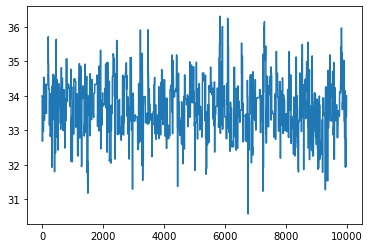

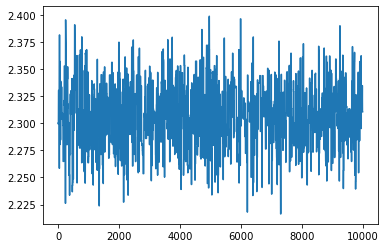

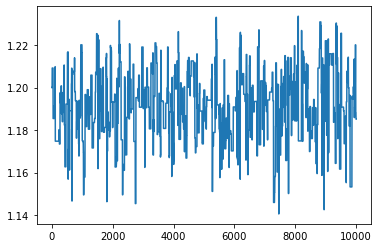

In [36]:
plt.plot(model.samples[:,0])
plt.show()
plt.plot(model.samples[:,1])
plt.show()
plt.plot(model.samples[:,2])
plt.show()

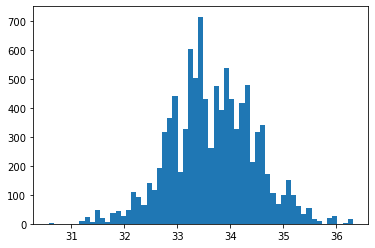

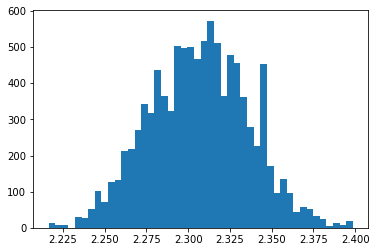

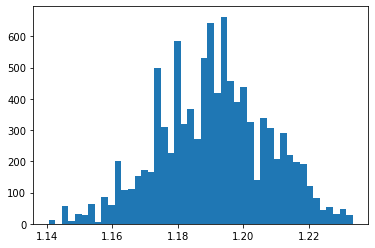

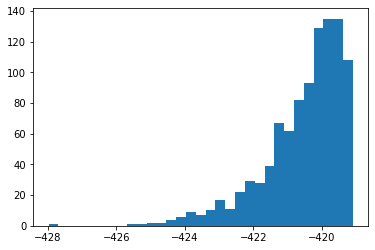

In [39]:
plt.hist(model.samples[::10,0], bins='auto')
plt.show()
plt.hist(model.samples[::10,1], bins='auto')
plt.show()
plt.hist(model.samples[::10,2], bins='auto')
plt.show()
plt.hist(model.lls[::10], bins='auto')
plt.show()

In [45]:
def eps_adjust(X, Y):
    models = [MH_sampler_poisson(X, Y, eps=(e,e,e)).sampling(10**4, (34, 2.3, 1.2))
             for e in [0.01,0.1,1]]
    for i in range(3):
        plt.plot([0.01, 0.1, 1], 
                 [model.accepts[i::3].sum() / model.accepts[i::3].size for model in models],
                 marker='o')
        plt.axhline(0.5, color='k')
        plt.title("amw"[i])
        plt.xscale('log')
        plt.ylim(0,1)
        plt.show()

<ipython-input-31-f36609644ec1>:15: RuntimeWarning: divide by zero encountered in log
  return (self.Y*np.log(f)-f).sum()-self.lgammas
<ipython-input-31-f36609644ec1>:15: RuntimeWarning: invalid value encountered in multiply
  return (self.Y*np.log(f)-f).sum()-self.lgammas


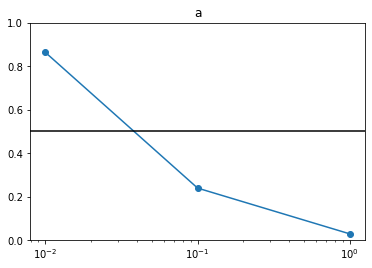

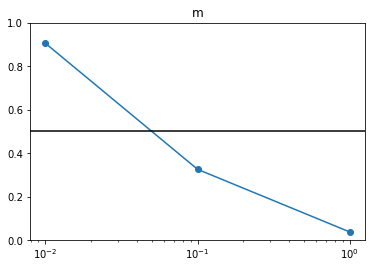

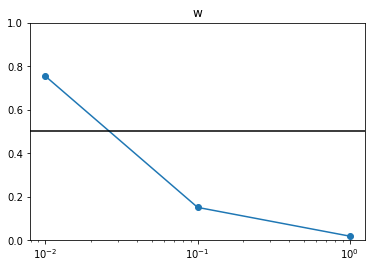

In [46]:
eps_adjust(X, Y)

In [48]:
model = MH_sampler_poisson(X, Y, eps=(0.03,0.05,0.02))\
    .sampling(10**5, (34, 2.3, 1.2))

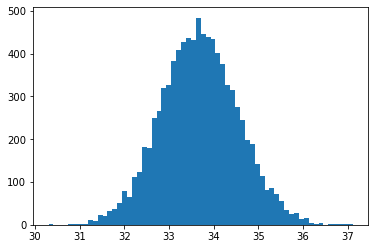

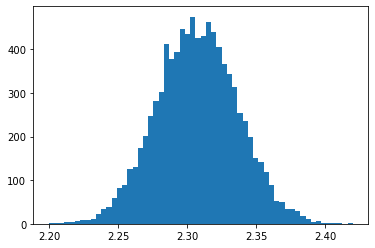

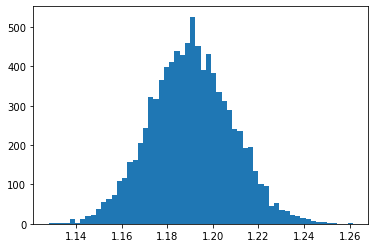

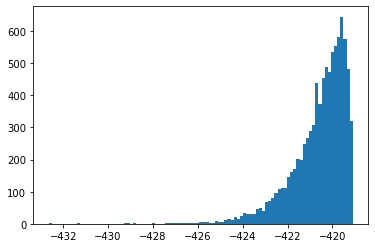

In [53]:
plt.hist(model.samples[10**4::10,0], bins='auto')
plt.show()
plt.hist(model.samples[10**4::10,1], bins='auto')
plt.show()
plt.hist(model.samples[10**4::10,2], bins='auto')
plt.show()
plt.hist(model.lls[10**4::10], bins='auto')
plt.show()

In [118]:
def logit(p):
    p = min(max(p,1e-8),1-1e-8)
    return np.log(p/(1-p))
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

In [122]:
def eps_adjust_logit(X, Y, beta=1.0):
    epss = np.array([0.1,1,10])
    models = [MH_sampler_poisson(X, Y, eps=(e,e,e), beta=beta).sampling(10**4, (34, 2.3, 1.2))
             for e in epss]
    for i in range(3):
        logits = np.array(
            [logit(model.accepts[i::3].sum() / model.accepts[i::3].size)
             for model in models])
        a = ((np.log10(epss)*logits).mean()-np.log10(epss).mean()*logits.mean())\
            /((np.log10(epss)**2).mean()-np.log10(epss).mean()**2)
        b = logits.mean() - a*np.log10(epss).mean()
        r = (-1-b)/a
        plt.plot(np.log10(epss), logits, marker='o')
        plt.axhline(-1, color='k')
        plt.axvline(r, color='k')
        plt.title(f"{'amw'[i]} ({10**r:.2e})")
        #plt.ylim(0,1)
        plt.xlabel(r'$\log_{10}\varepsilon$')
        plt.ylabel(r'logit $p$')
        plt.show()
        yield 10**r

<ipython-input-64-6ca7c9776e1a>:16: RuntimeWarning: divide by zero encountered in log
  return ((self.Y*np.log(f)-f).sum()-self.lgammas) * self.beta
<ipython-input-64-6ca7c9776e1a>:16: RuntimeWarning: invalid value encountered in multiply
  return ((self.Y*np.log(f)-f).sum()-self.lgammas) * self.beta


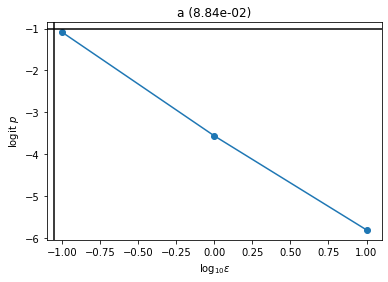

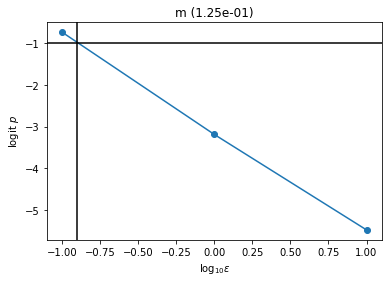

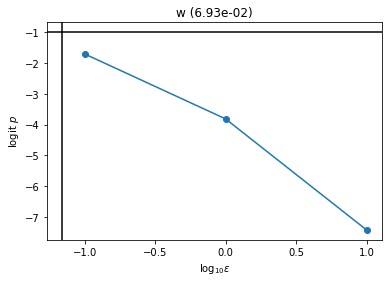

Wall time: 4.22 s


In [123]:
%%time
*epss, = eps_adjust_logit(X, Y)

In [101]:
(*epss,)

(0.08572995680280178, 0.14243712912657147, 0.05135348198788366)

In [88]:
10**np.linspace(-8,0,17)

array([1.00000000e-08, 3.16227766e-08, 1.00000000e-07, 3.16227766e-07,
       1.00000000e-06, 3.16227766e-06, 1.00000000e-05, 3.16227766e-05,
       1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00])

In [151]:
def bayes_factor(X, Y, betas=10**np.linspace(-8,0,9), sample_size=10**5):
    for beta in betas:
        print(beta)
        *epss, = eps_adjust_logit(X, Y, beta)
        
        model = MH_sampler_poisson(X, Y, eps=(*epss,), beta=beta)\
            .sampling(sample_size, (34, 2.3, 1.2))
        plt.hist(np.log10(model.samples[sample_size//10::10,0]), bins='auto', density=True)
        plt.xlabel('log10 a')
        plt.show()
        plt.hist(model.samples[sample_size//10::10,1], bins='auto', density=True)
        plt.xlabel('m')
        plt.show()
        plt.hist(np.log10(model.samples[sample_size//10::10,2]), bins='auto', density=True)
        plt.xlabel('log10 w')
        plt.show()
        plt.hist(model.lls[sample_size//10::10]/beta, bins='auto', density=True)
        plt.xlabel('log Likelifood')
        plt.show()
        print([model.accepts[i::3].sum() / model.accepts[i::3].size
             for i in range(3)])
        
        yield (model.lls[sample_size//10::10]/beta).mean()

1e-08


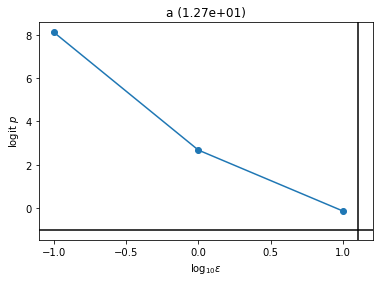

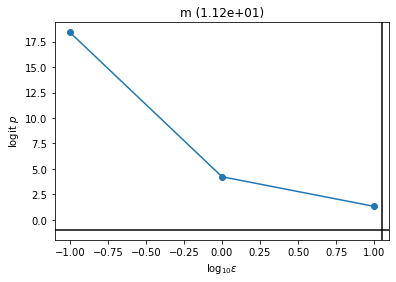

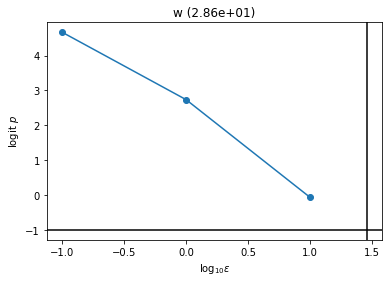

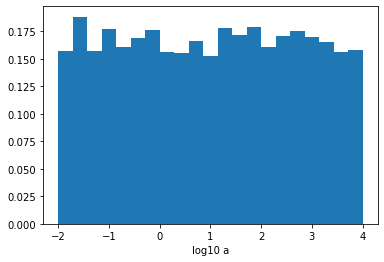

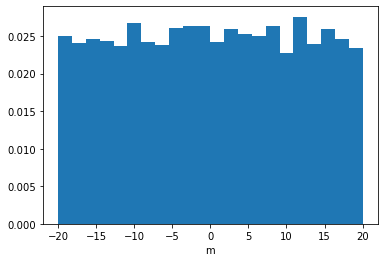

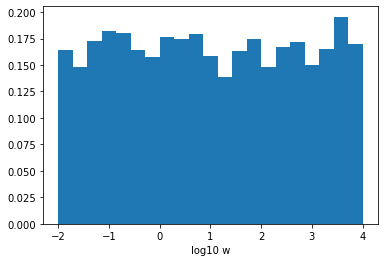

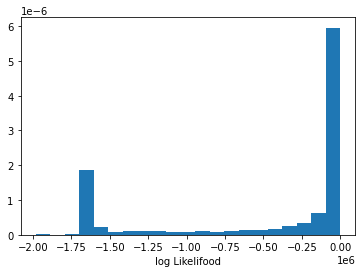

[0.3923921521569569, 0.7812378123781237, 0.18720187201872018]
1e-07


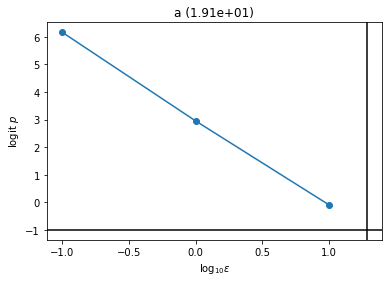

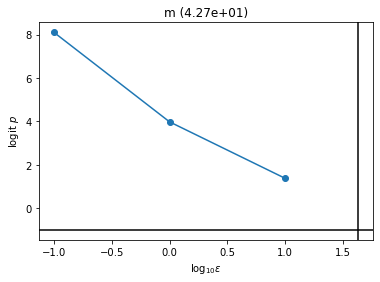

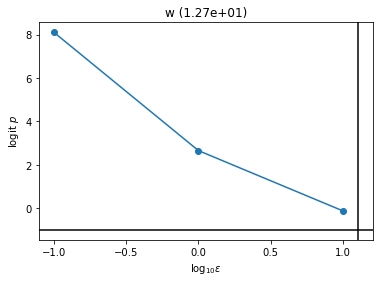

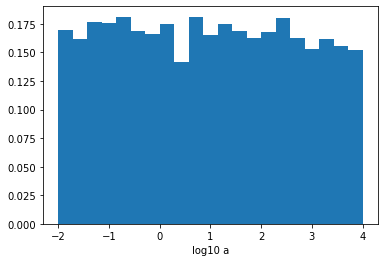

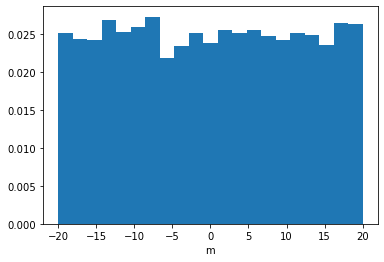

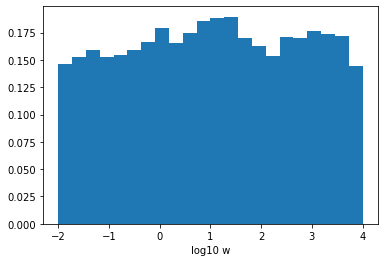

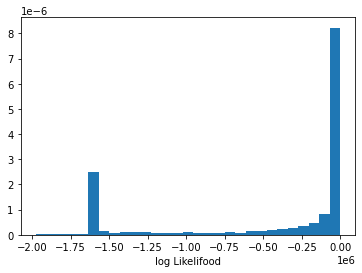

[0.2768044639107218, 0.34776347763477633, 0.3838538385383854]
1e-06


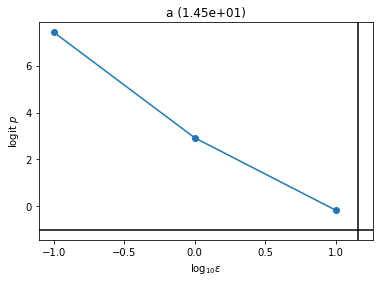

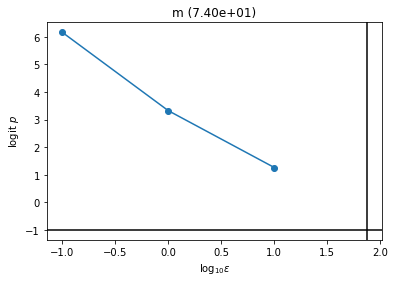

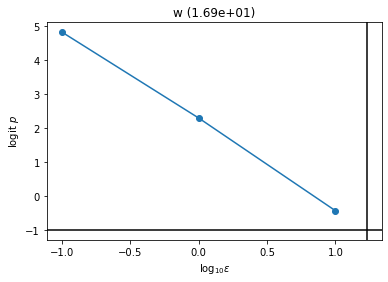

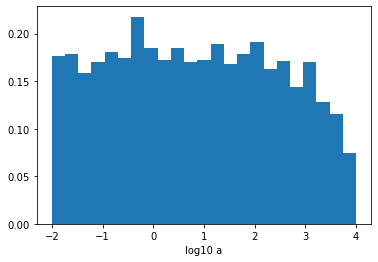

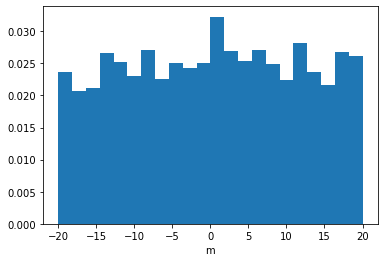

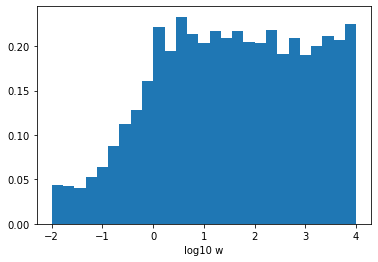

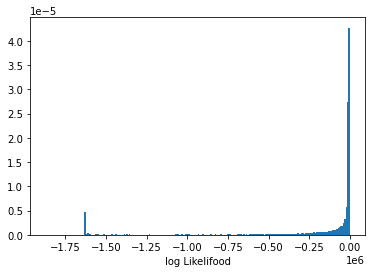

[0.33605327893442133, 0.2069120691206912, 0.24978249782497824]
1e-05


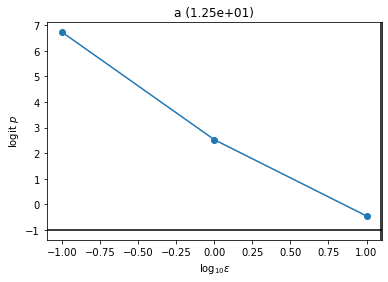

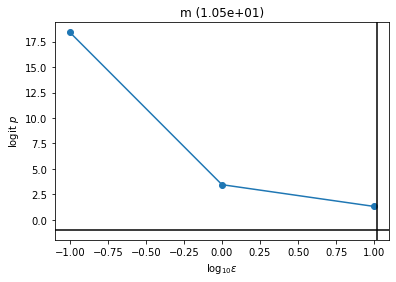

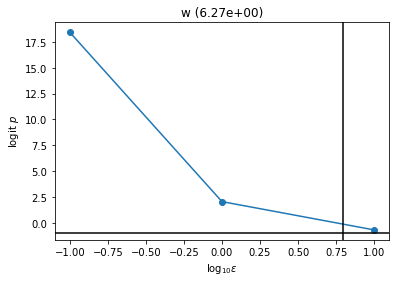

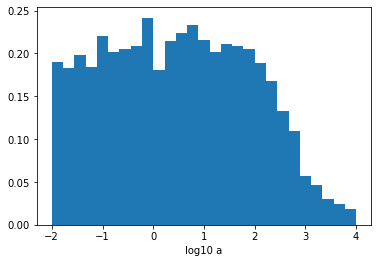

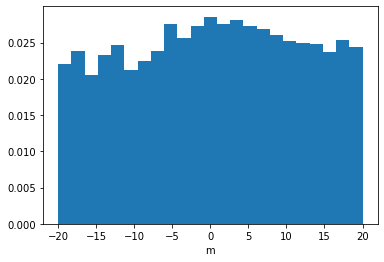

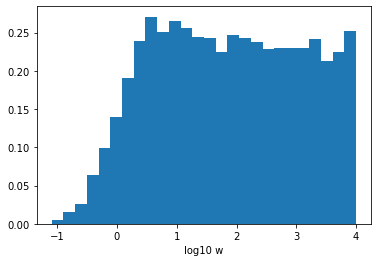

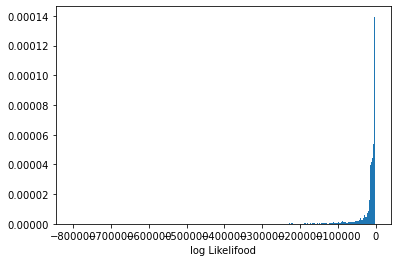

[0.3253134937301254, 0.7532775327753277, 0.48732487324873247]
0.0001


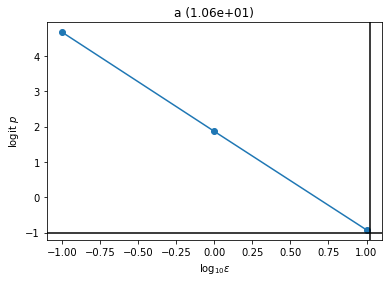

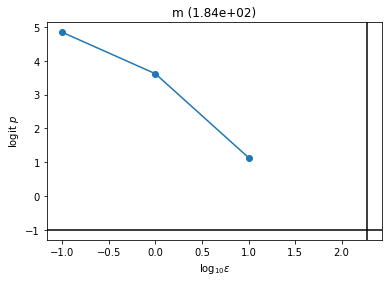

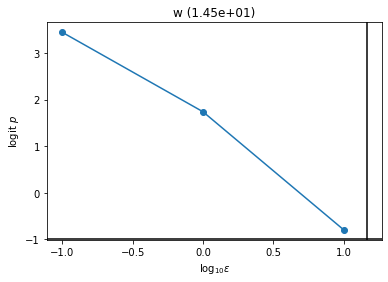

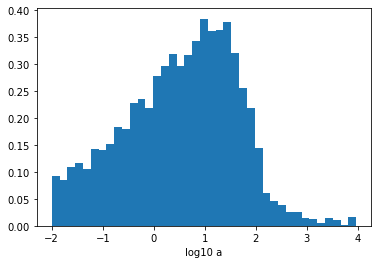

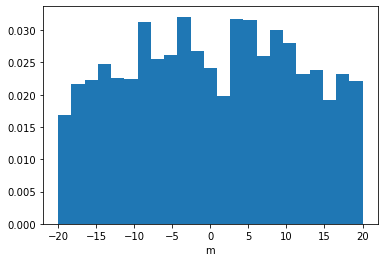

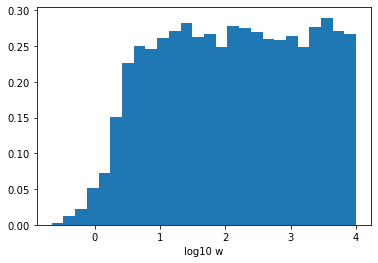

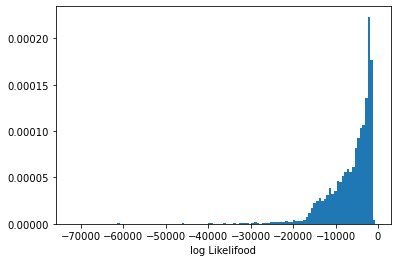

[0.2644447111057779, 0.07737077370773708, 0.2158821588215882]
0.001


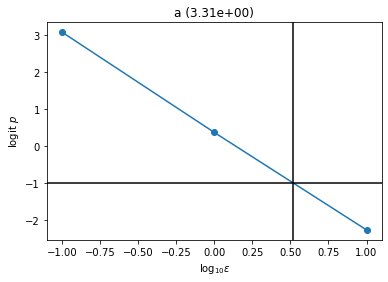

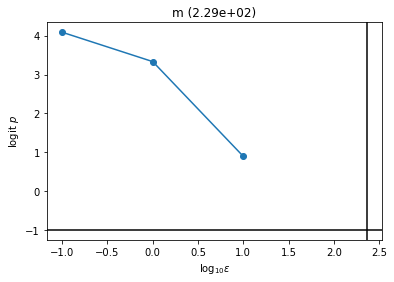

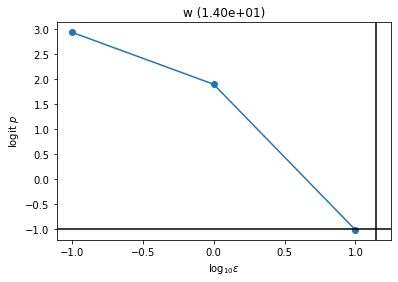

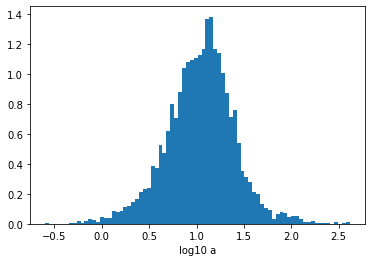

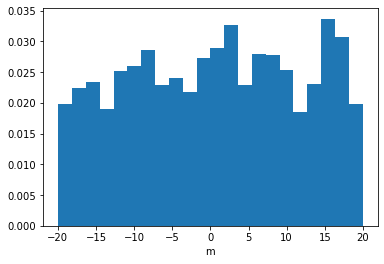

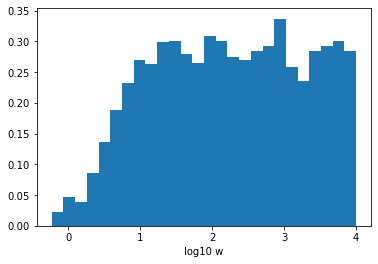

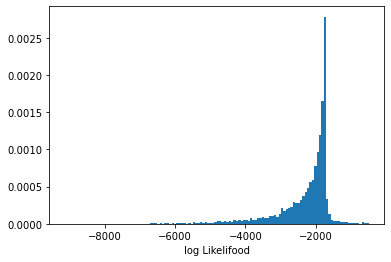

[0.25187496250075, 0.06255062550625506, 0.1946719467194672]
0.01


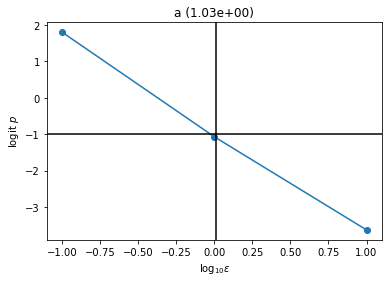

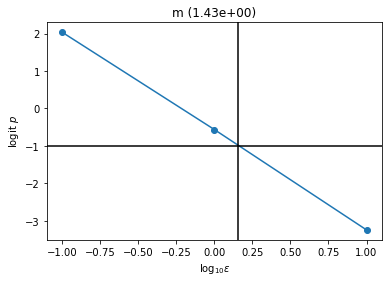

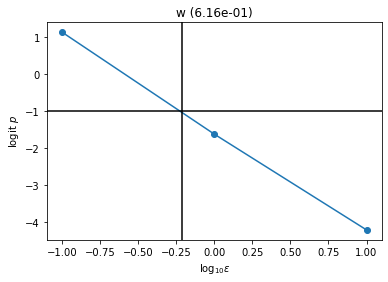

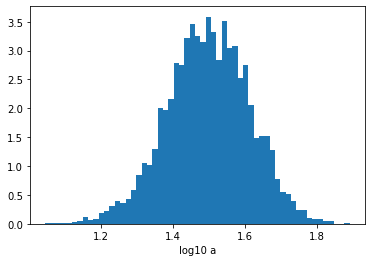

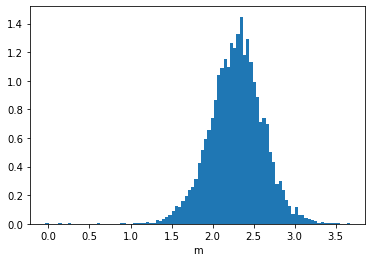

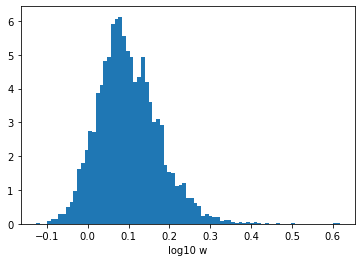

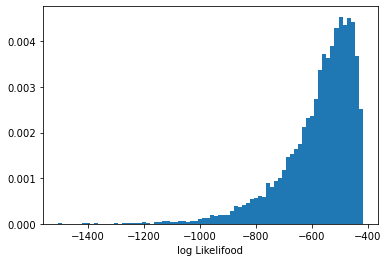

[0.24416511669766605, 0.26058260582605824, 0.2543425434254343]
0.1


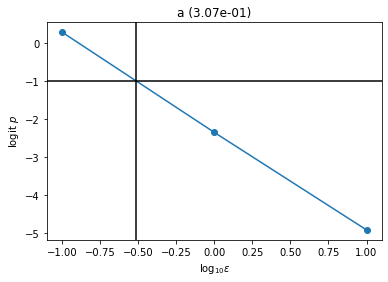

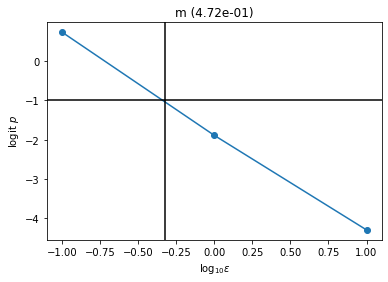

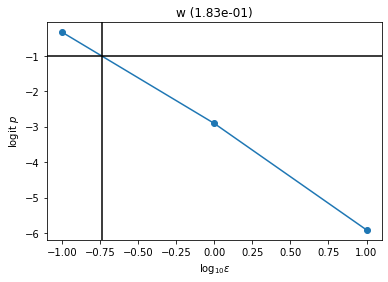

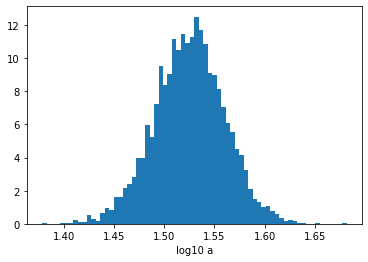

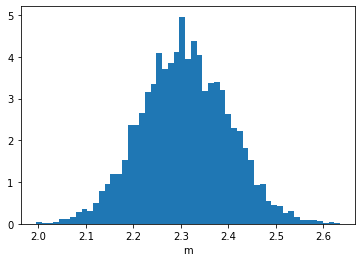

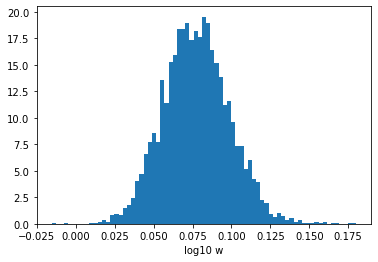

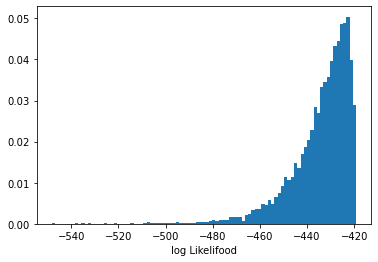

[0.251844963100738, 0.23676236762367622, 0.2527225272252723]
1.0


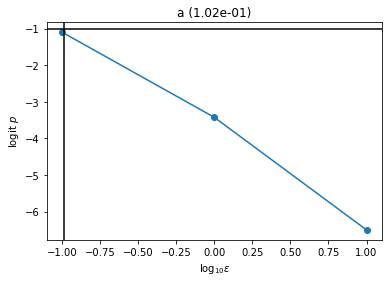

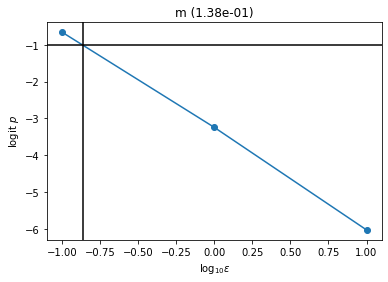

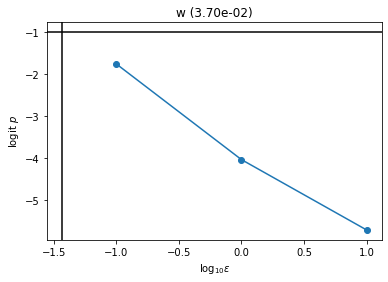

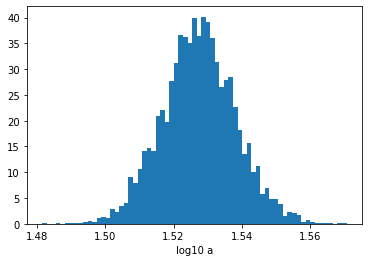

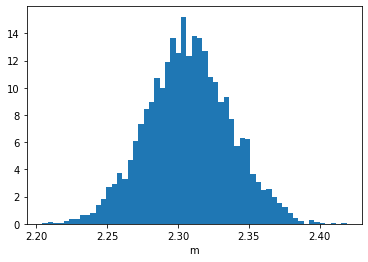

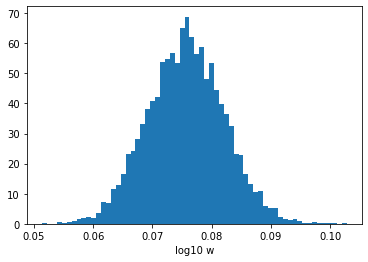

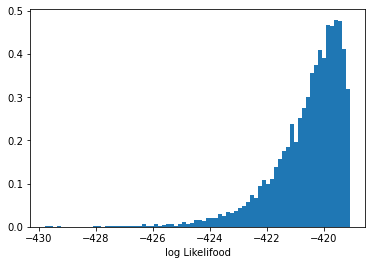

[0.23957520849583008, 0.25023250232502325, 0.37722377223772235]


In [152]:
*llss, = bayes_factor(X, Y)

(-49403135949352.99, 0.0)

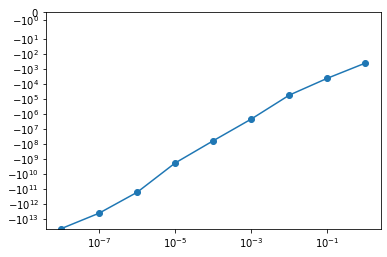

In [153]:
plt.plot(10**np.linspace(-8,0,9), llss/(10**np.linspace(-8,0,9)), marker='o')
plt.xscale('log')
plt.yscale('symlog')
plt.ylim(None,0)

1e-10


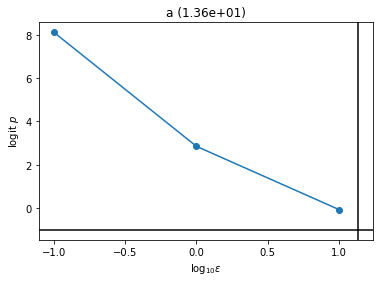

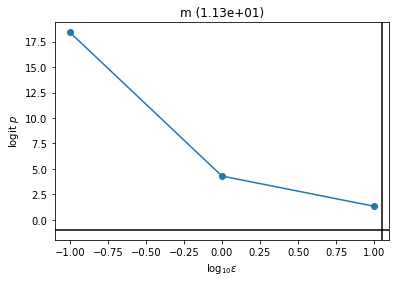

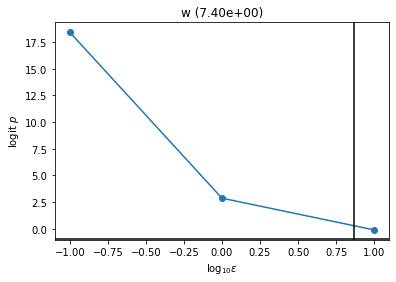

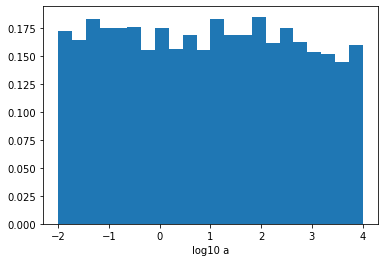

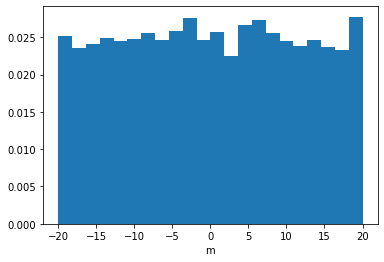

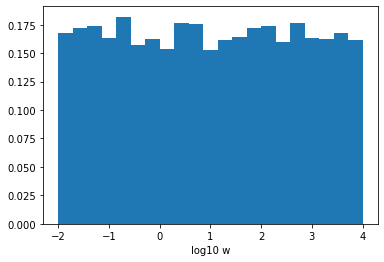

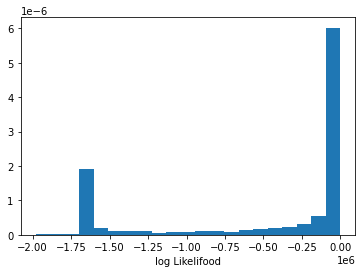

[0.374392512149757, 0.7729877298772988, 0.5838058380583806]
3.1622776601683795e-10


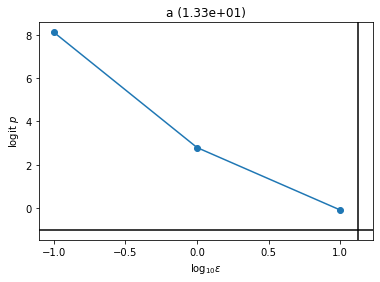

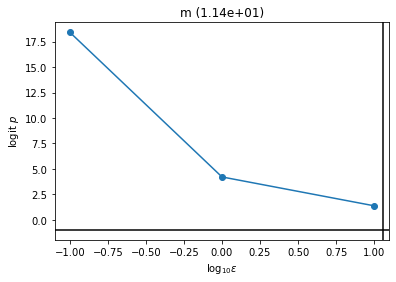

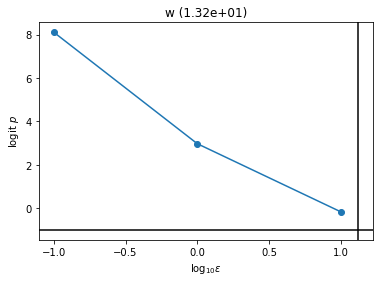

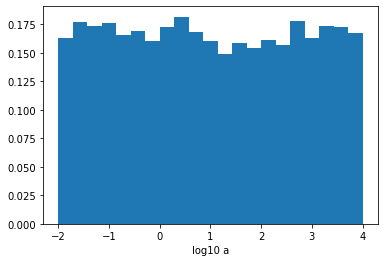

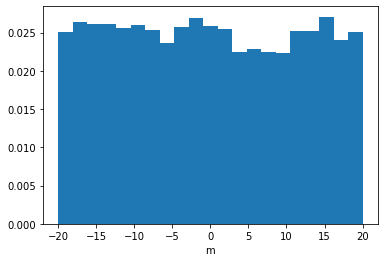

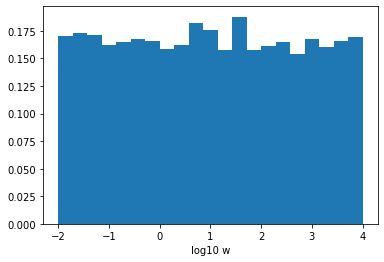

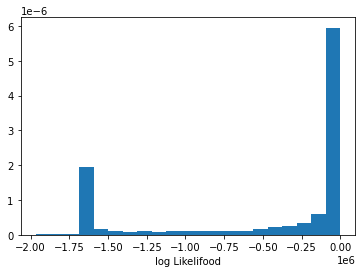

[0.37670246595068096, 0.7691176911769118, 0.37875378753787536]
1e-09


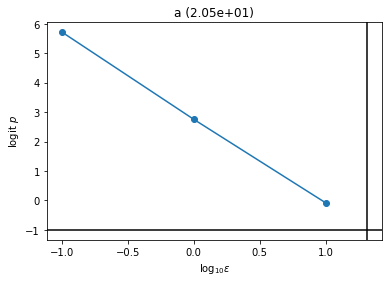

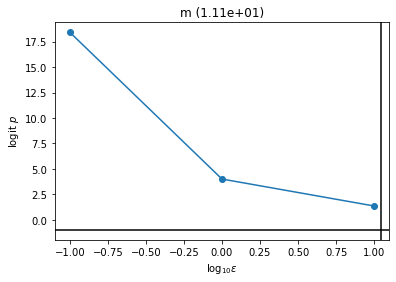

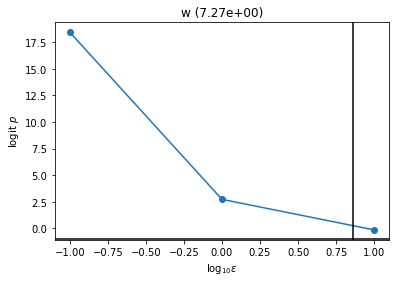

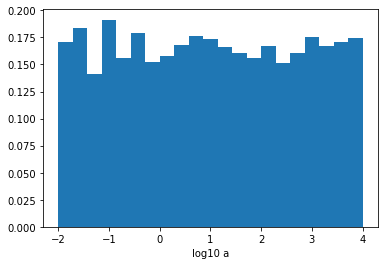

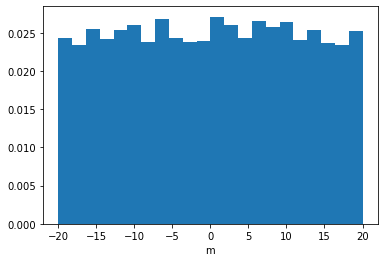

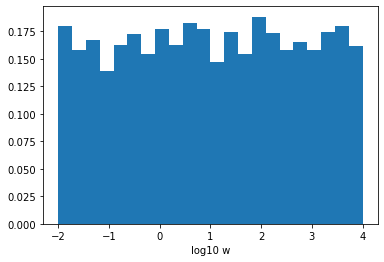

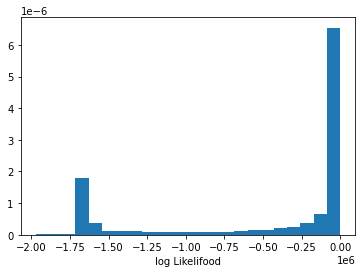

[0.2614447711045779, 0.7808178081780818, 0.5910959109591096]
3.1622776601683795e-09


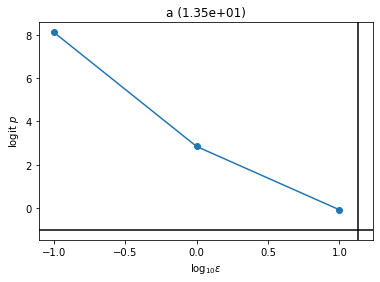

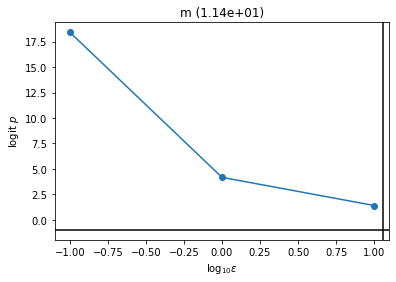

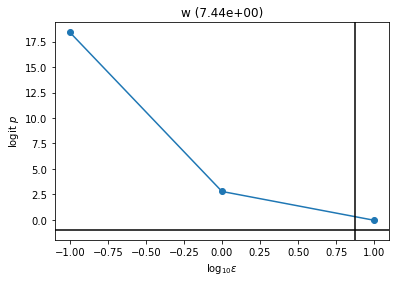

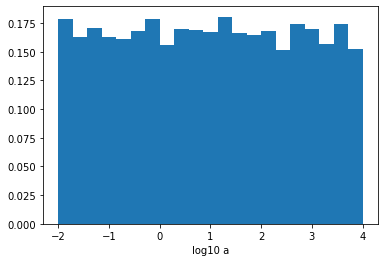

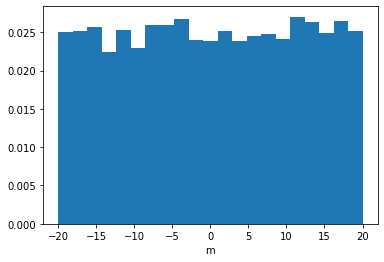

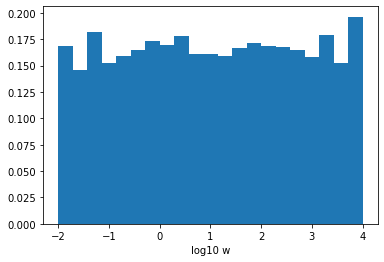

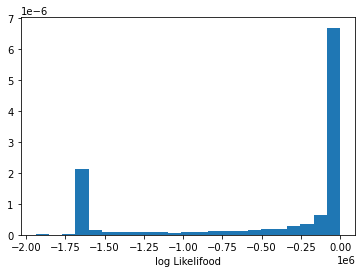

[0.372952540949181, 0.7713077130771308, 0.5837758377583776]
1e-08


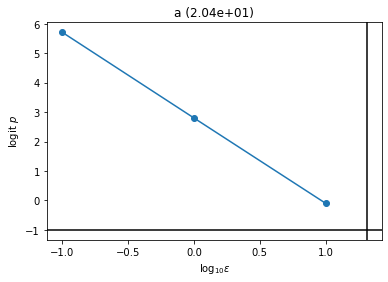

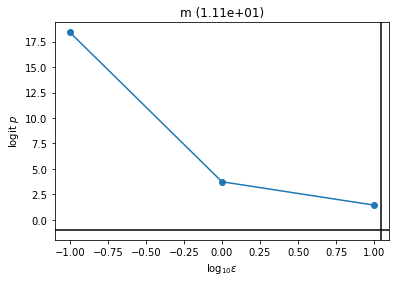

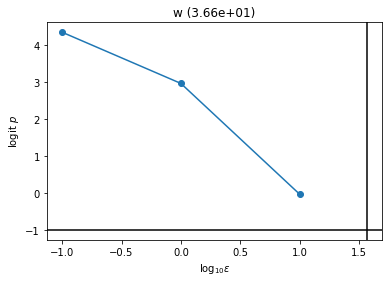

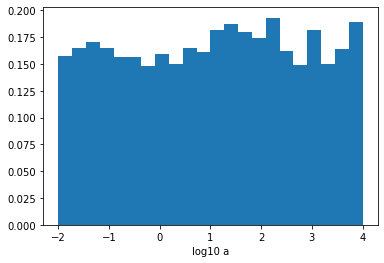

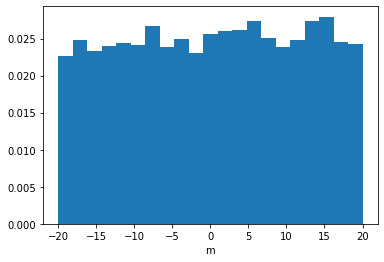

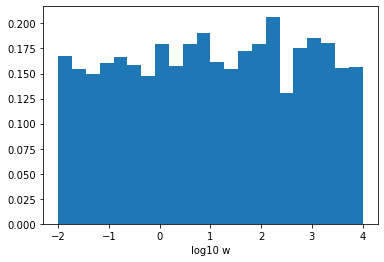

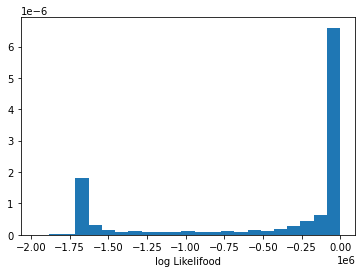

[0.254604907901842, 0.7851378513785138, 0.15048150481504816]
3.162277660168379e-08


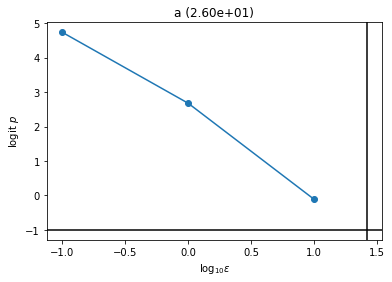

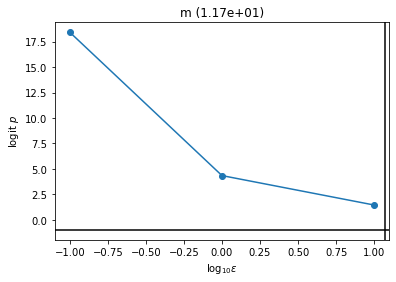

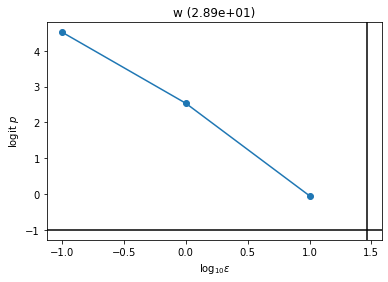

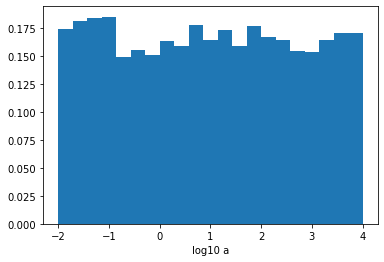

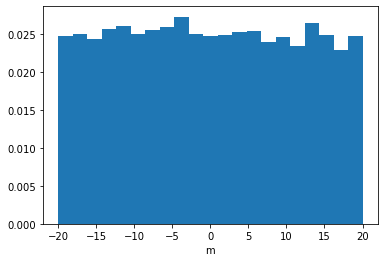

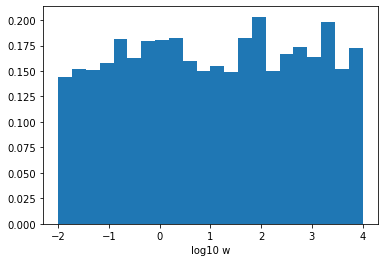

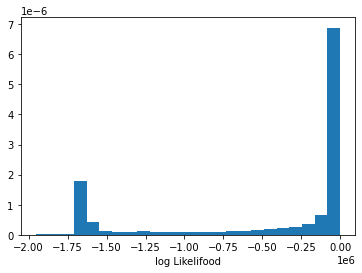

[0.20789584208315834, 0.7658176581765818, 0.1892718927189272]
1e-07


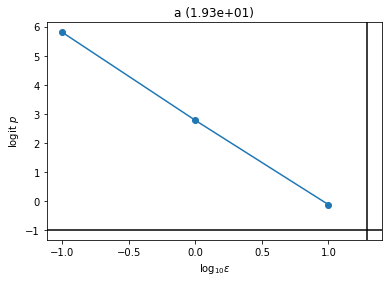

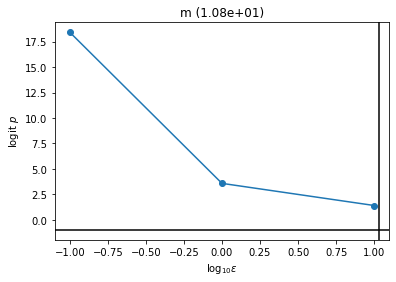

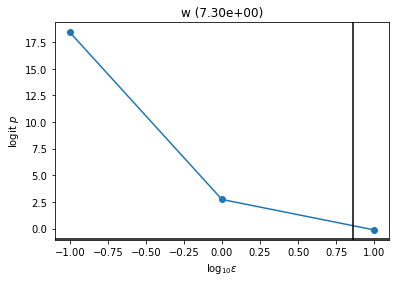

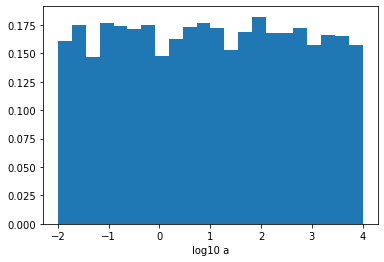

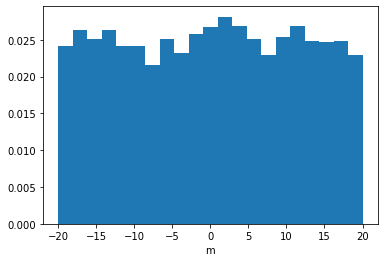

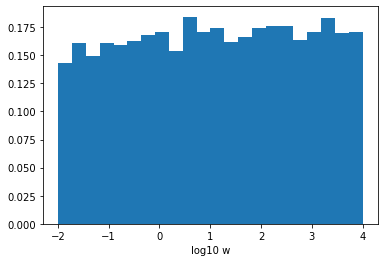

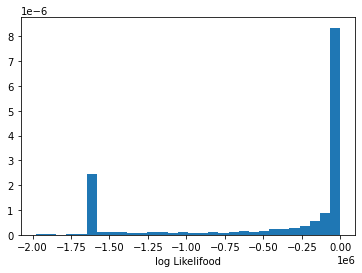

[0.2707745845083098, 0.7825578255782558, 0.5766657666576666]
3.162277660168379e-07


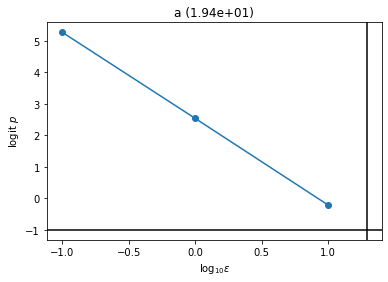

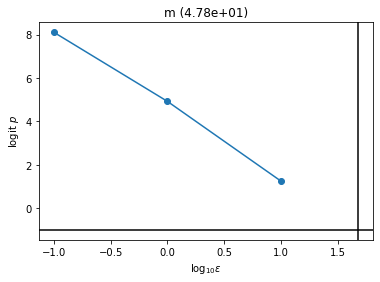

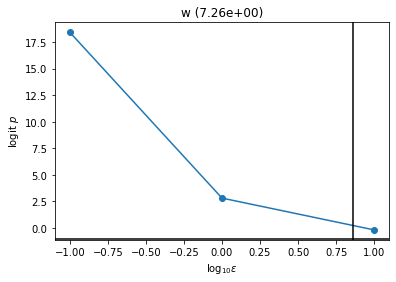

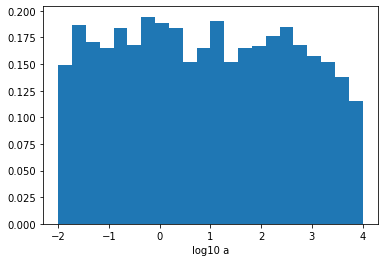

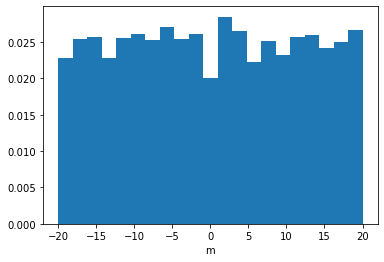

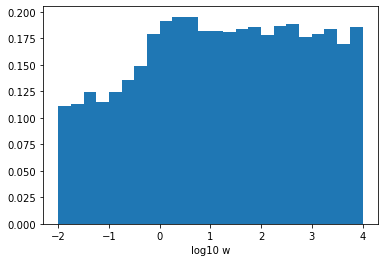

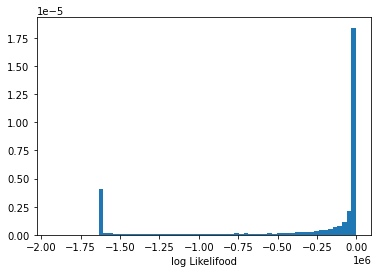

[0.26936461270774587, 0.3117631176311763, 0.5590255902559026]
1e-06


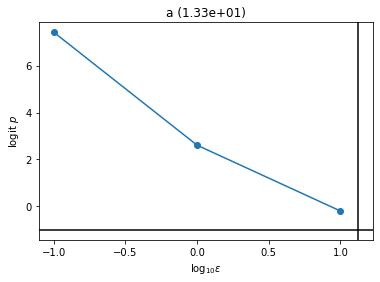

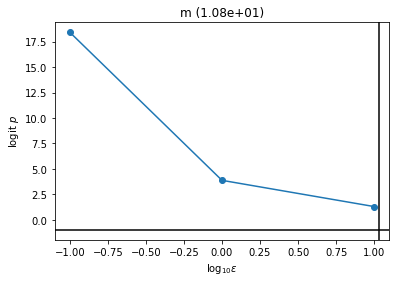

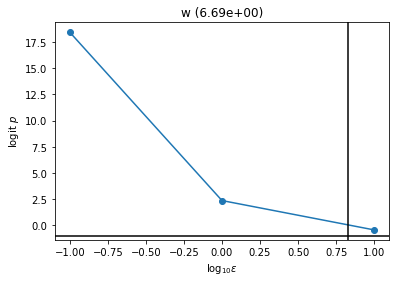

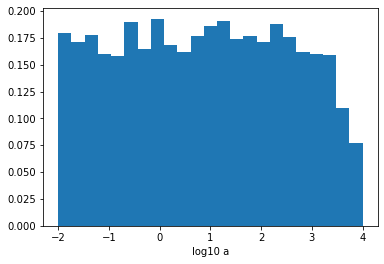

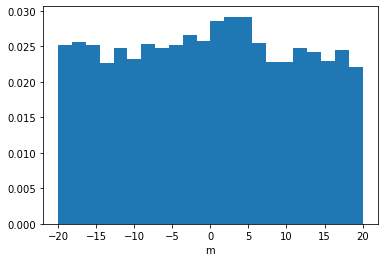

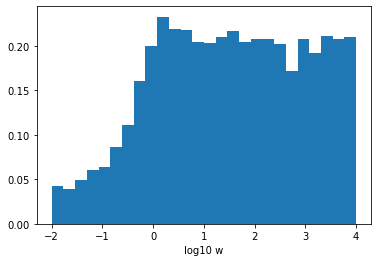

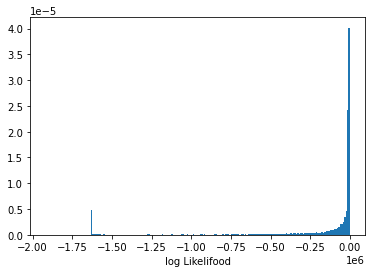

[0.3614027719445611, 0.7635676356763568, 0.5360153601536015]
3.162277660168379e-06


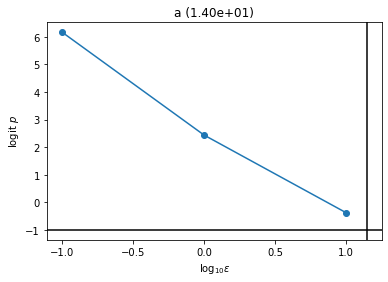

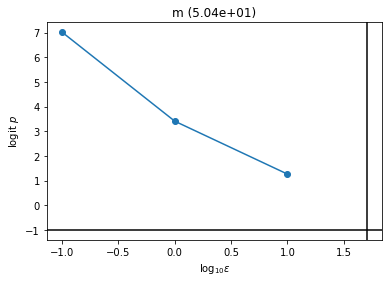

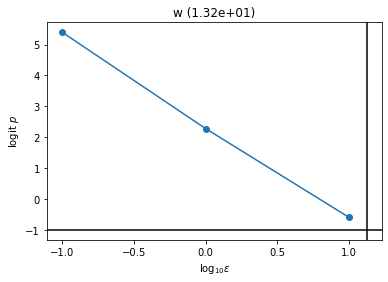

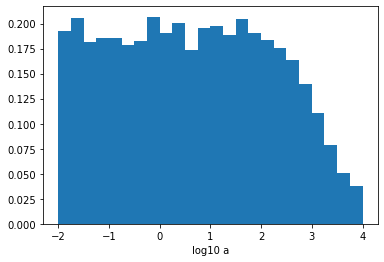

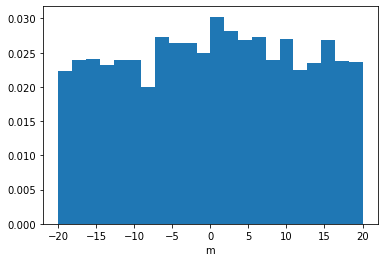

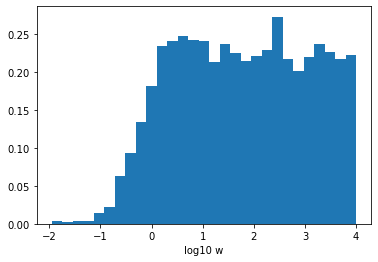

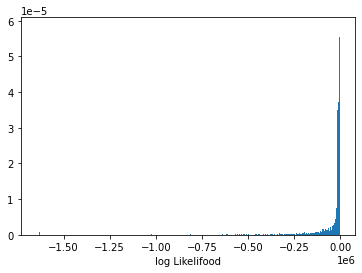

[0.3242335153296934, 0.2875528755287553, 0.28149281492814926]
1e-05


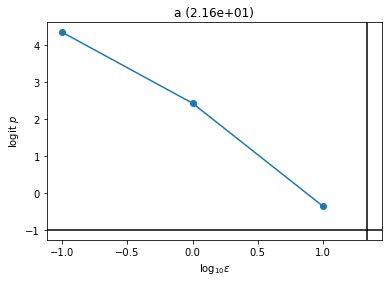

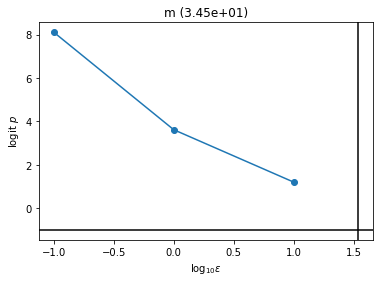

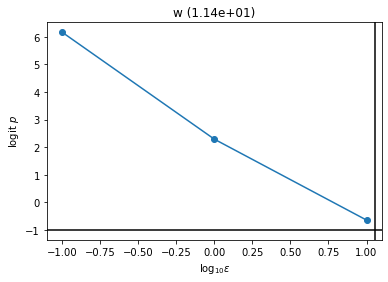

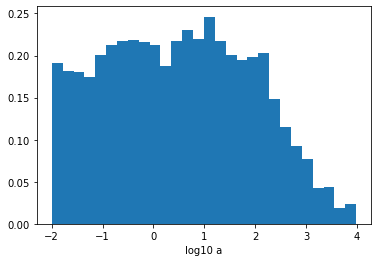

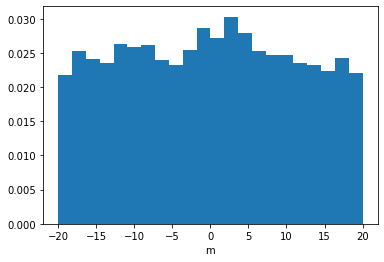

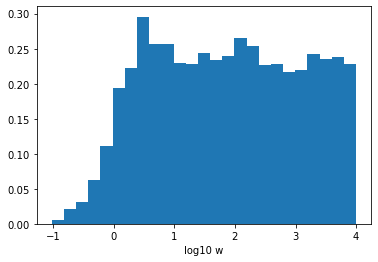

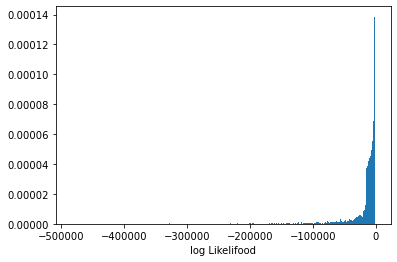

[0.1999460010799784, 0.3935139351393514, 0.3012930129301293]
3.1622776601683795e-05


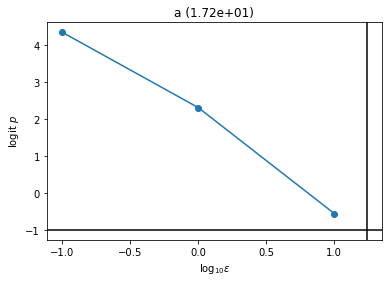

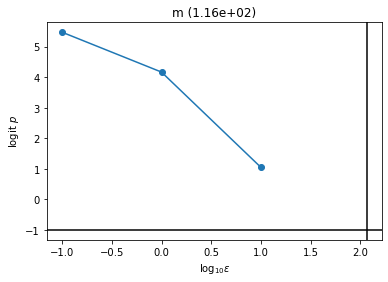

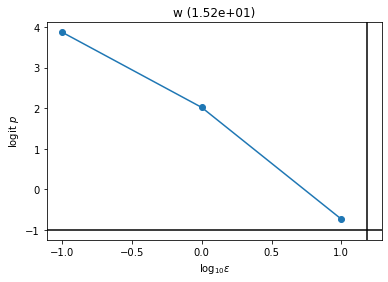

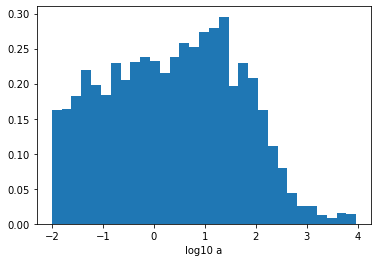

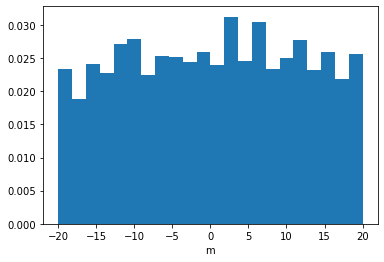

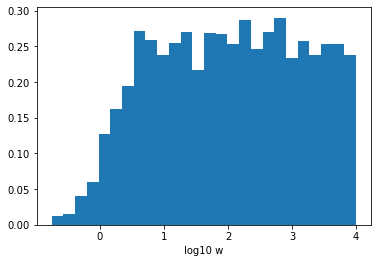

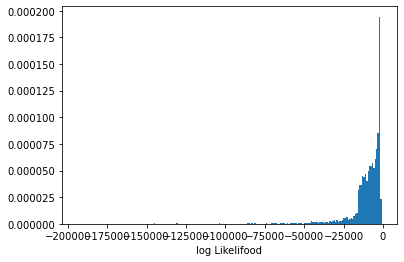

[0.21596568068638627, 0.12576125761257612, 0.21489214892148922]
0.0001


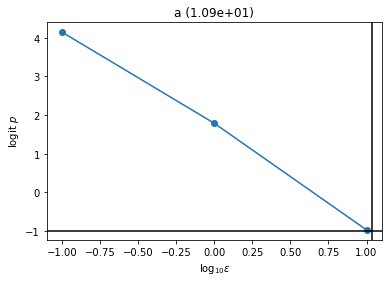

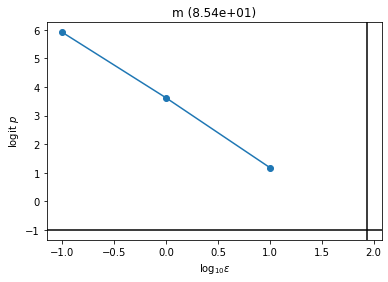

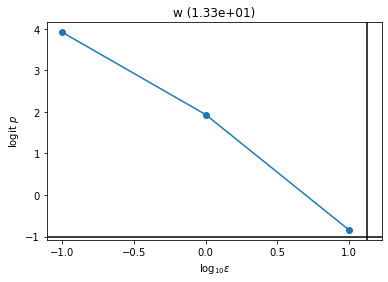

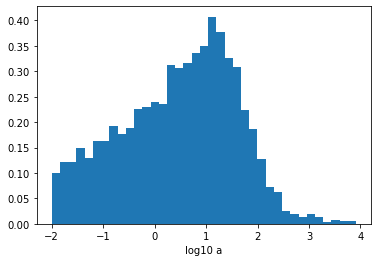

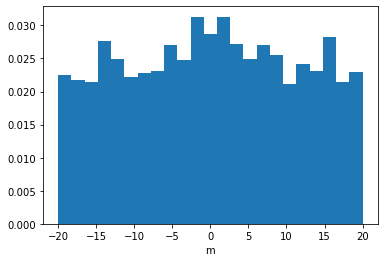

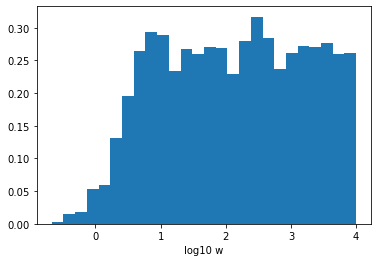

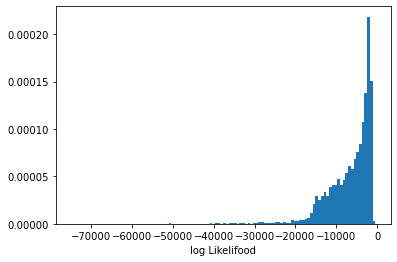

[0.2619547609047819, 0.17469174691746917, 0.22896228962289622]
0.00031622776601683794


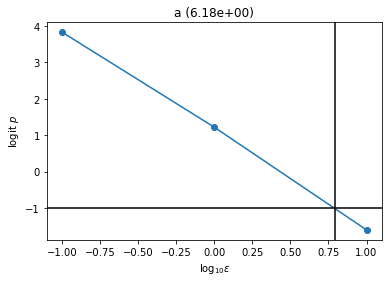

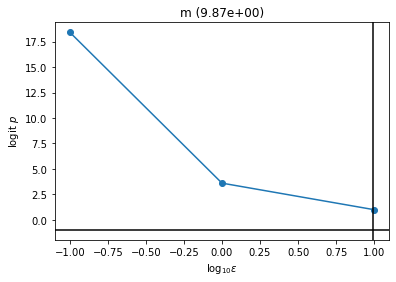

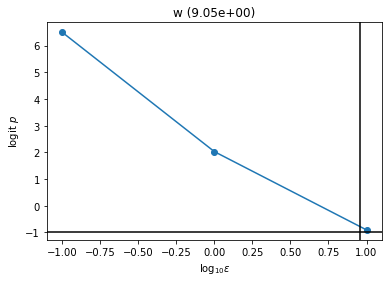

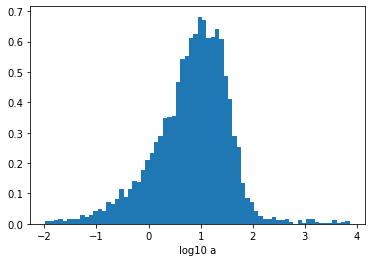

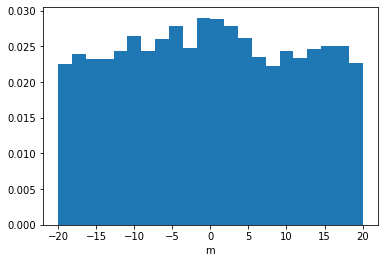

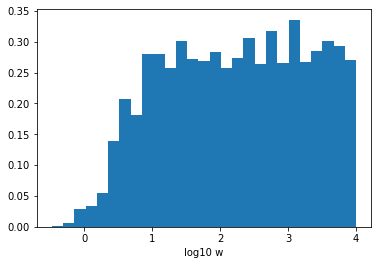

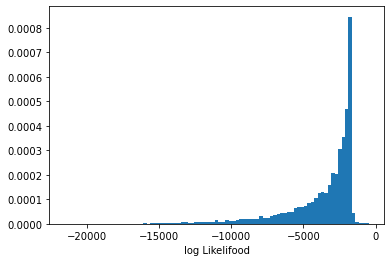

[0.26675466490670185, 0.7574175741757417, 0.3111031110311103]
0.001


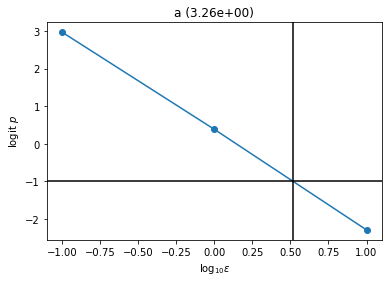

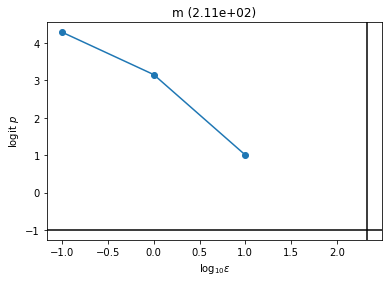

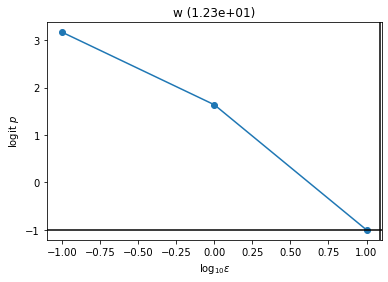

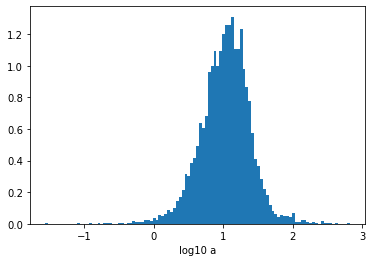

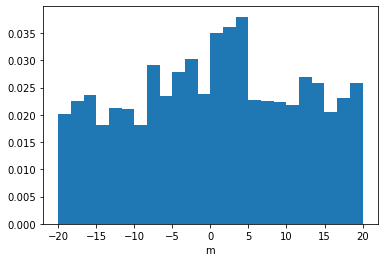

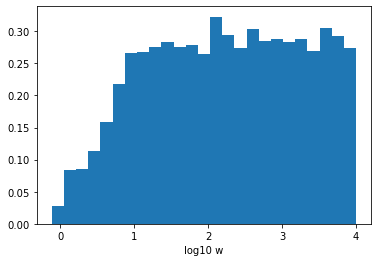

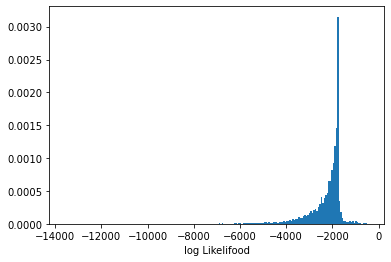

[0.25313493730125397, 0.06708067080670807, 0.22215222152221523]
0.0031622776601683794


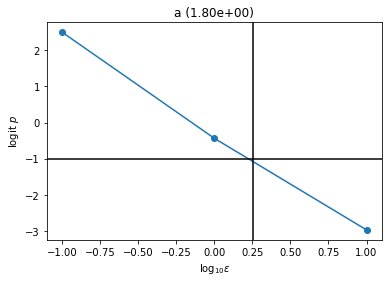

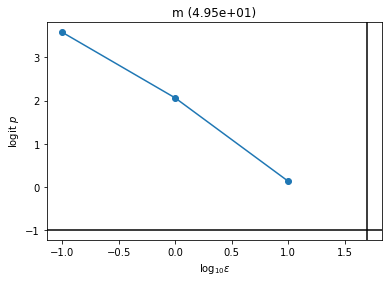

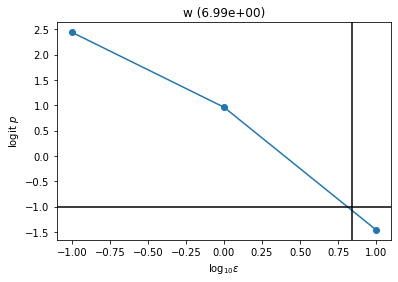

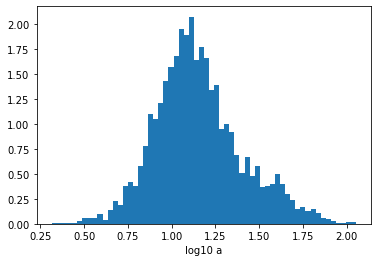

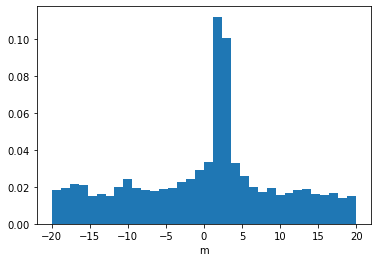

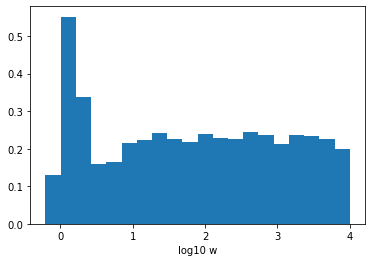

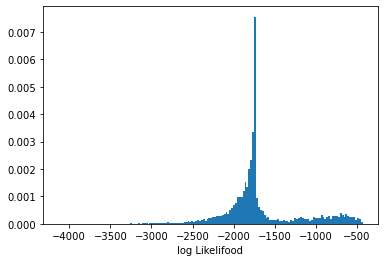

[0.24815503689926202, 0.21282212822128221, 0.2834728347283473]
0.01


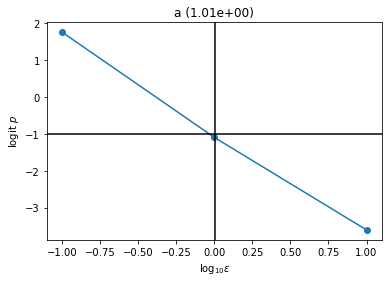

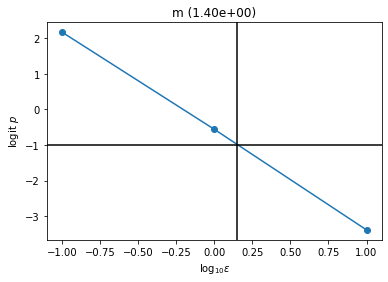

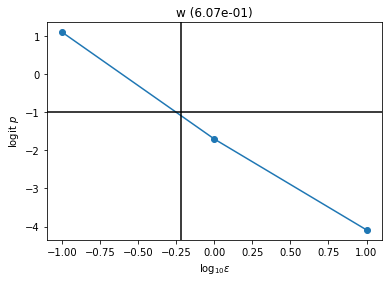

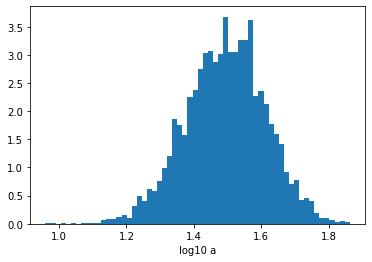

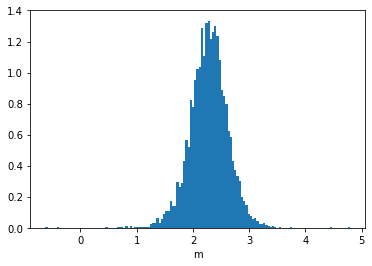

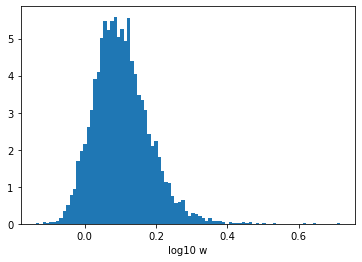

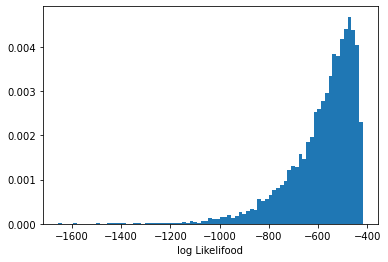

[0.24422511549769005, 0.27189271892718925, 0.25572255722557224]
0.03162277660168379


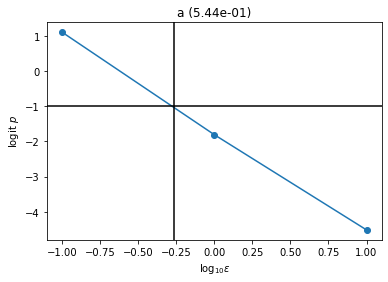

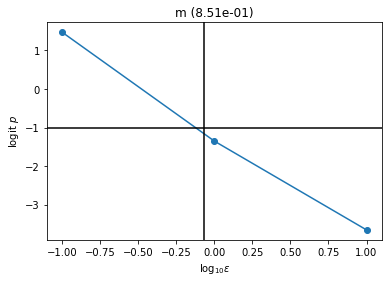

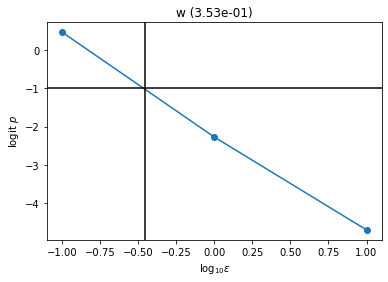

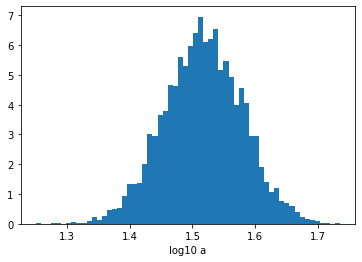

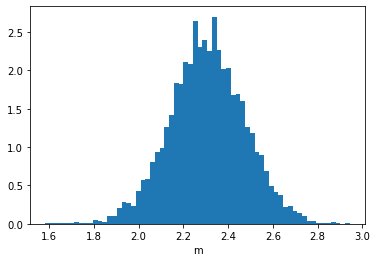

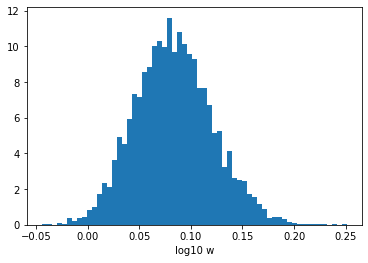

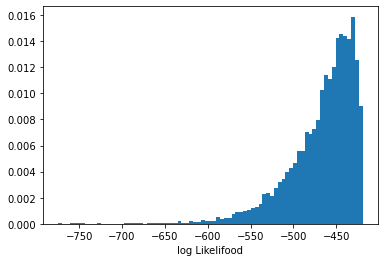

[0.25862482750344995, 0.23820238202382024, 0.23823238232382324]
0.1


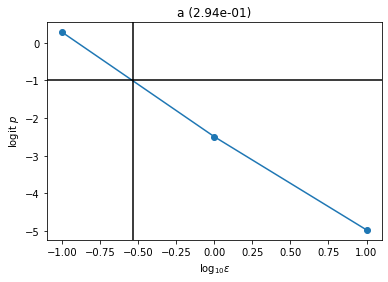

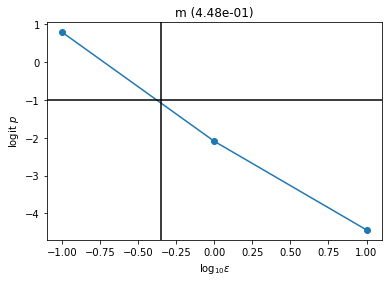

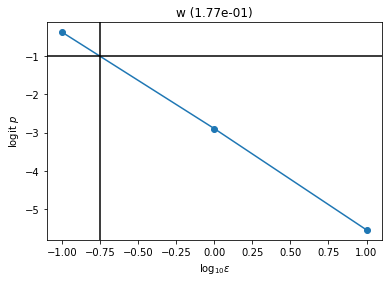

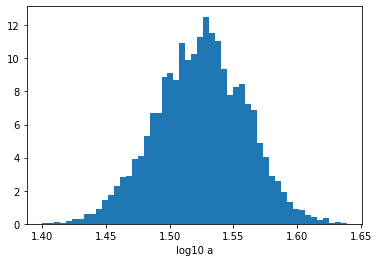

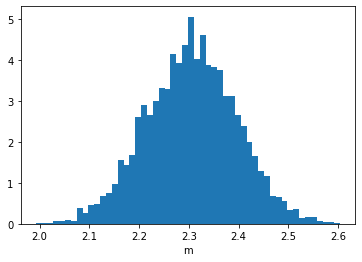

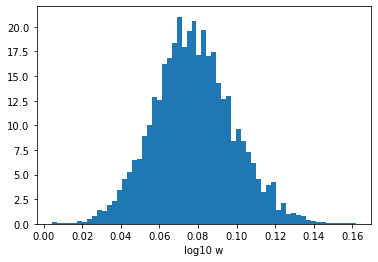

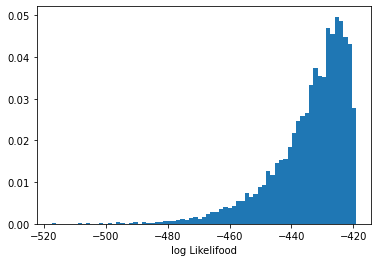

[0.26864462710745785, 0.24945249452494525, 0.26307263072630727]
0.31622776601683794


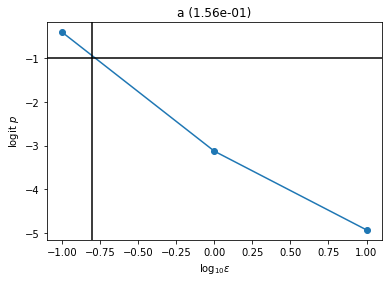

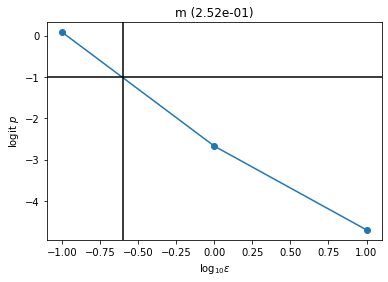

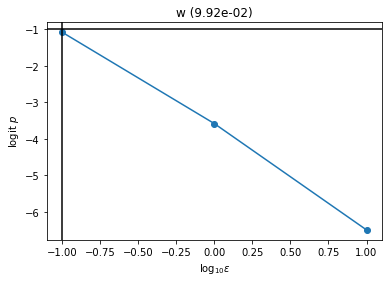

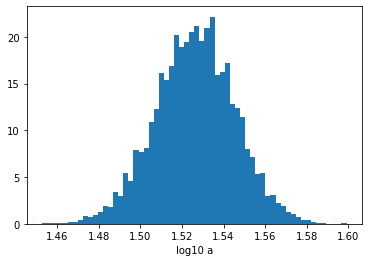

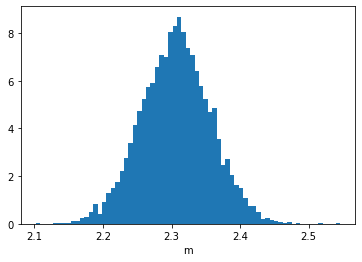

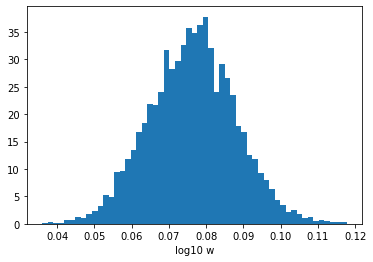

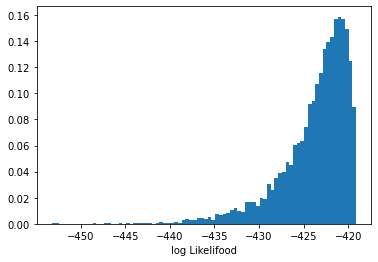

[0.27950440991180175, 0.24078240782407825, 0.25887258872588725]
1.0


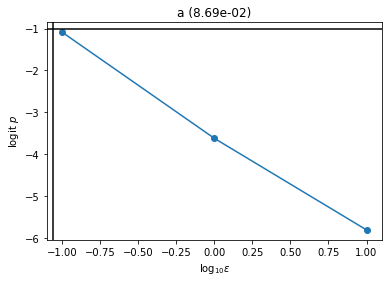

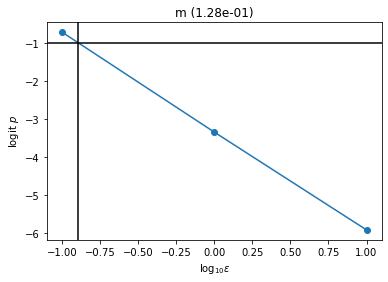

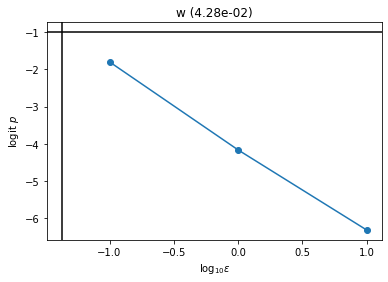

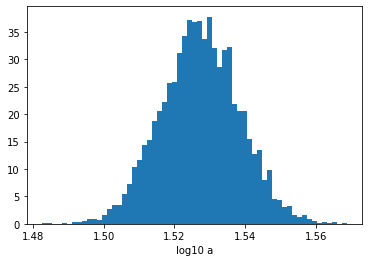

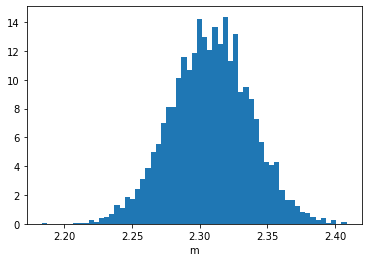

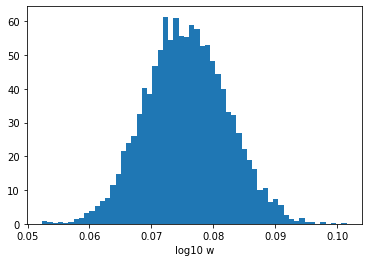

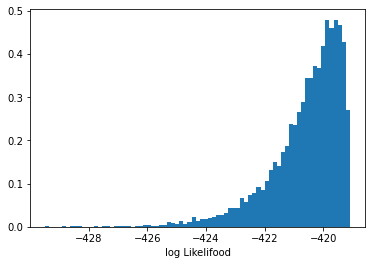

[0.2854142917141657, 0.26910269102691026, 0.33090330903309034]


In [154]:
*llss, = bayes_factor(X, Y, betas=10**np.linspace(-10, 0, 21))

(-4968049281374265.0, 0.0)

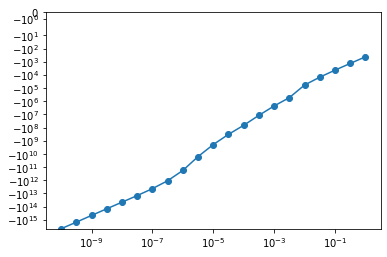

In [155]:
plt.plot(10**np.linspace(-10, 0, 21), llss/(10**np.linspace(-10, 0, 21)), marker='o')
plt.xscale('log')
plt.yscale('symlog')
plt.ylim(None,0)

In [156]:
import pickle
with open('poisson_ll.bin', mode='wb') as f:
    pickle.dump(llss, f)

In [159]:
betas = 10**np.linspace(-10, 0, 21)

In [162]:
(np.array(llss) * np.diff([0, *np.convolve(betas, [0.5,0.5], mode='valid'),1 ])).sum()

-440.33569328073474

In [171]:
class MH_sampler_gaussian(object):
    def __init__(self, X, Y, eps=(0.1, 0.1, 0.1), beta=1.0, random_state=None):
        self.eps = eps
        self.random_state = random_state
        self.random = np.random
        self.random.seed(random_state)
        self.X = X
        self.Y = Y
        self.beta = beta
        self.lgammas = sum(math.lgamma(y+1) for y in Y)
    
    def logLikelihood(self, a, m, w):
        if not(1e-2<a<1e4 and -20<m<20 and 1e-2<w<1e4):
            return -np.inf
        f = peek(self.X, a, m, w)
        f2 = f**2 + 1e-300
        return (-(self.Y - f)**2/2/f2 - np.log(2*np.pi*f2)/2).sum() * self.beta

    def sampling(self, samplesize=10**4, init=(1, 1, 1)):
        pre_param = init
        samples = [pre_param]
        accepts = [False]
        pre_ll = self.logLikelihood(*pre_param)
        lls = [pre_ll]
        for i in range(1, samplesize):
            a,m,w = pre_param
            if i%3==0:
                la = np.log(a)
                la += self.random.normal(0, self.eps[0])
                a = np.exp(la)
            elif i%3==1:
                m += self.random.normal(0, self.eps[1])
            else:
                lw = np.log(w)
                lw += self.random.normal(0, self.eps[2])
                w = np.exp(lw)
            new_ll = self.logLikelihood(a, m, w)
            #print(a,m,w,new_ll)
            if new_ll>=pre_ll or self.random.rand() <= np.exp(-pre_ll+new_ll):
                accepts += [True]
                pre_param = (a, m, w)
                pre_ll = new_ll
            else:
                accepts += [False]
            samples += [pre_param]
            lls += [pre_ll]
        self.samples = np.array(samples)
        self.accepts = np.array(accepts)
        self.lls = np.array(lls)
        return self

In [172]:
def eps_adjust_logit_g(X, Y, beta=1.0):
    epss = np.array([0.1,1,10])
    models = [MH_sampler_gaussian(X, Y, eps=(e,e,e), beta=beta).sampling(10**4, (34, 2.3, 1.2))
             for e in epss]
    for i in range(3):
        logits = np.array(
            [logit(model.accepts[i::3].sum() / model.accepts[i::3].size)
             for model in models])
        a = ((np.log10(epss)*logits).mean()-np.log10(epss).mean()*logits.mean())\
            /((np.log10(epss)**2).mean()-np.log10(epss).mean()**2)
        b = logits.mean() - a*np.log10(epss).mean()
        r = (-1-b)/a
        plt.plot(np.log10(epss), logits, marker='o')
        plt.axhline(-1, color='k')
        plt.axvline(r, color='k')
        plt.title(f"{'amw'[i]} ({10**r:.2e})")
        #plt.ylim(0,1)
        plt.xlabel(r'$\log_{10}\varepsilon$')
        plt.ylabel(r'logit $p$')
        plt.show()
        yield 10**r

In [198]:
def bayes_factor_g(X, Y, betas=10**np.linspace(-8,0,9), sample_size=10**5):
    for beta in betas:
        print(beta)
        *epss, = eps_adjust_logit_g(X, Y, beta)
        
        model = MH_sampler_gaussian(X, Y, eps=(*epss,), beta=beta)\
            .sampling(sample_size, (34, 2.3, 1.2))
        plt.hist(np.log10(model.samples[sample_size//10::10,0]), bins='auto', density=True)
        plt.xlabel('log10 a')
        plt.show()
        plt.hist(model.samples[sample_size//10::10,1], bins='auto', density=True)
        plt.xlabel('m')
        plt.show()
        plt.hist(np.log10(model.samples[sample_size//10::10,2]), bins='auto', density=True)
        plt.xlabel('log10 w')
        plt.show()
        plt.hist(model.lls[sample_size//10::10]/beta, bins='auto', density=True)
        plt.xlabel('log Likelifood')
        plt.show()
        print([model.accepts[i::3].sum() / model.accepts[i::3].size
             for i in range(3)])
        
        yield (model.lls[sample_size//10::10]/beta).mean()

1e-08


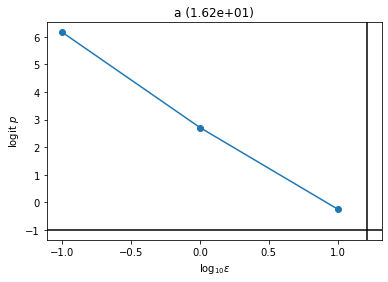

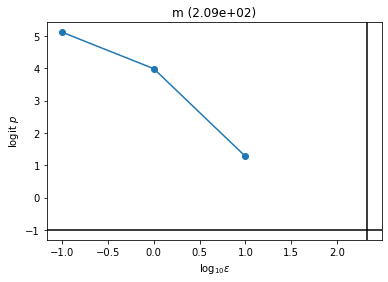

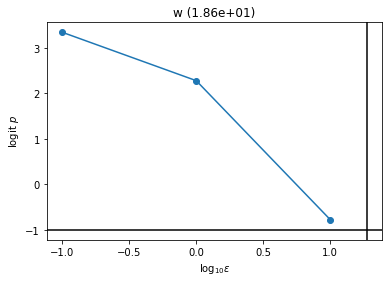

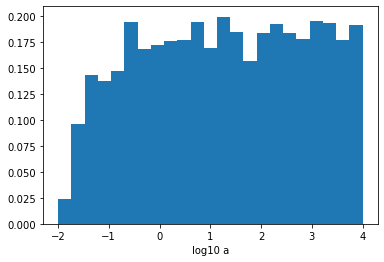

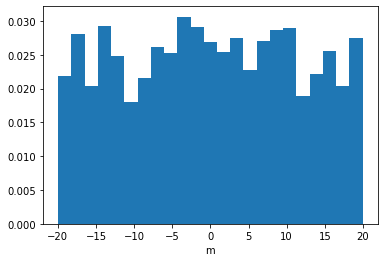

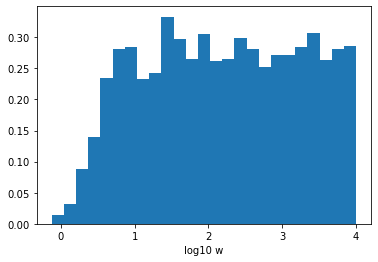

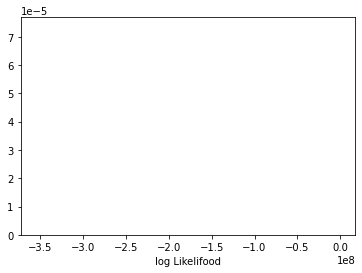

[0.29618407631847365, 0.07272072720727207, 0.17181171811718118]
1e-07


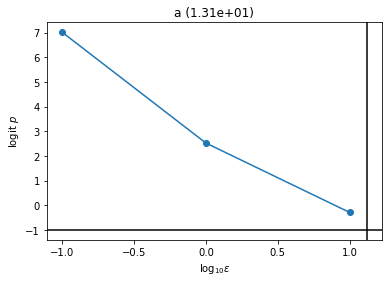

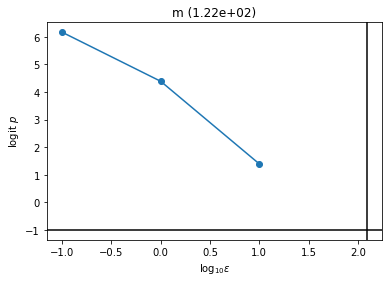

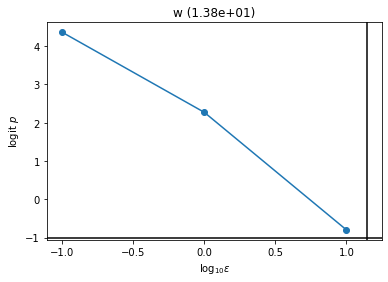

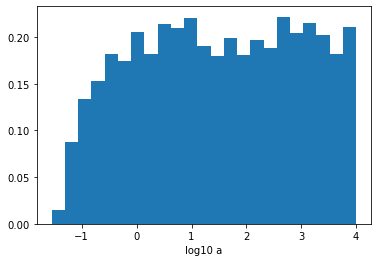

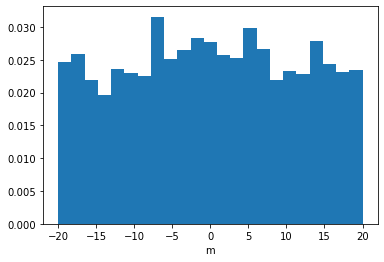

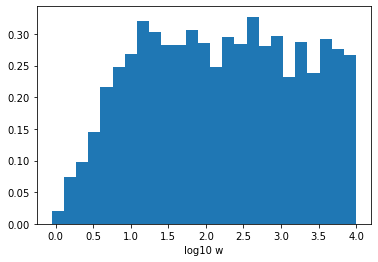

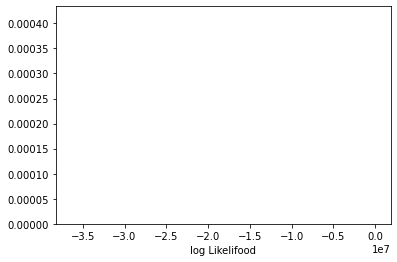

[0.33191336173276537, 0.12678126781267812, 0.22770227702277024]
1e-06


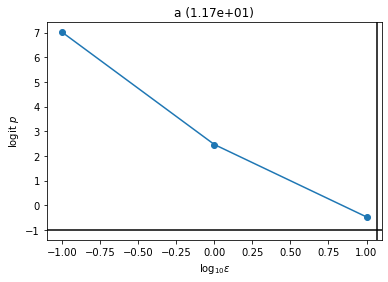

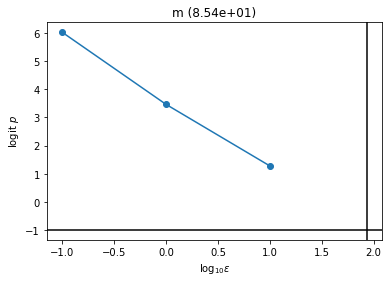

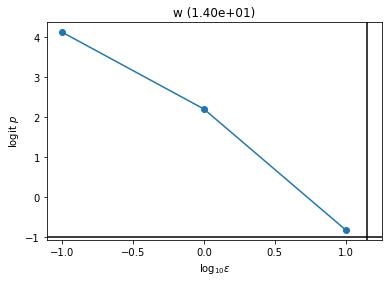

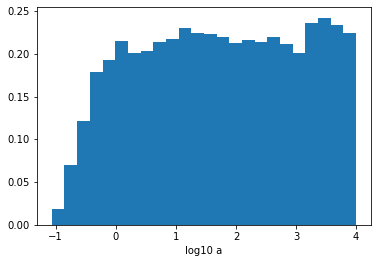

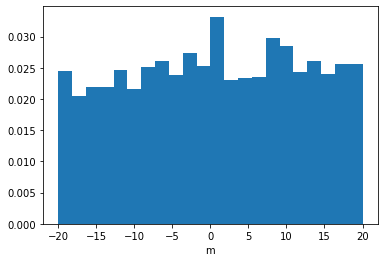

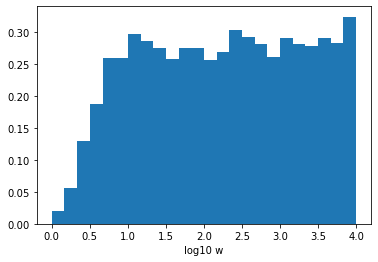

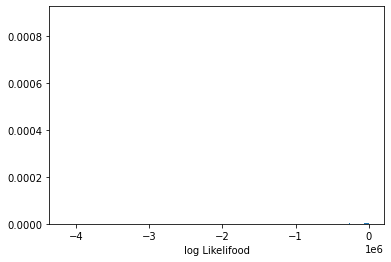

[0.33239335213295734, 0.17280172801728017, 0.22488224882248822]
1e-05


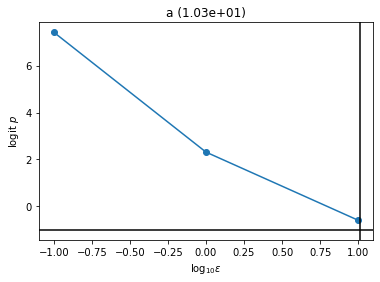

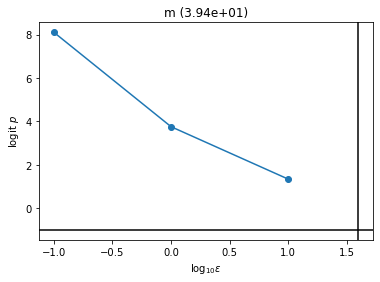

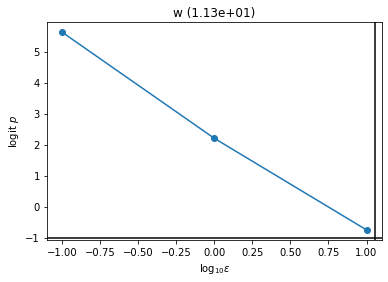

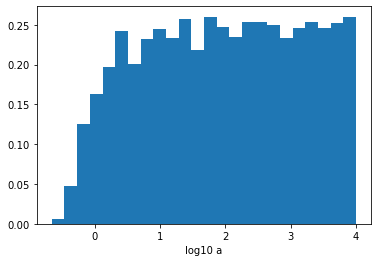

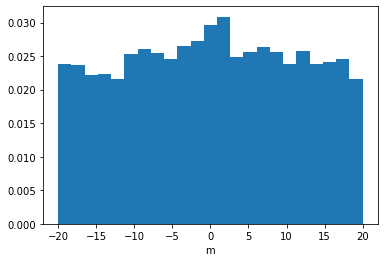

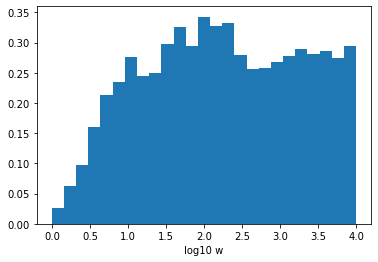

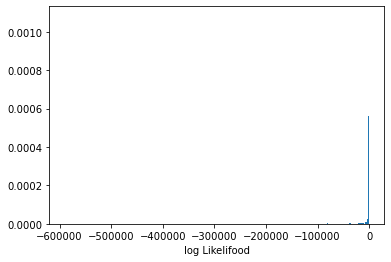

[0.34304313913721723, 0.3612936129361294, 0.2741127411274113]
0.0001


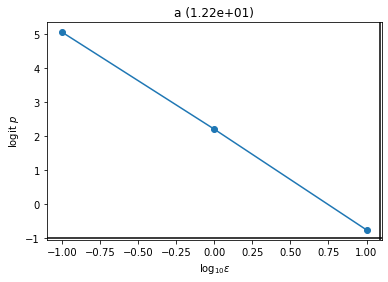

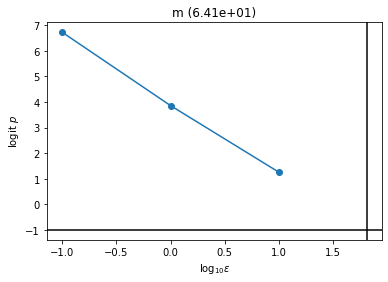

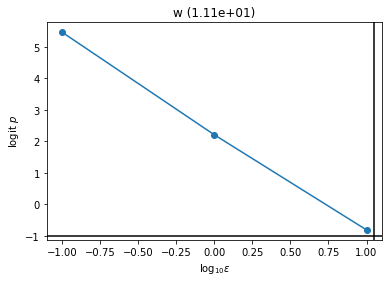

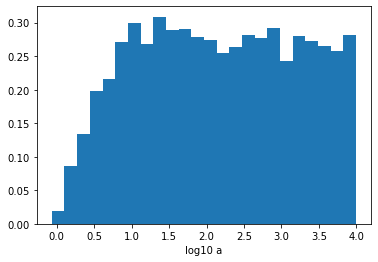

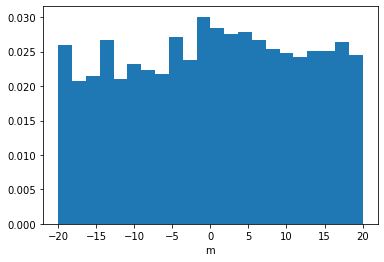

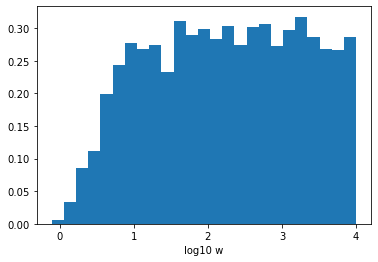

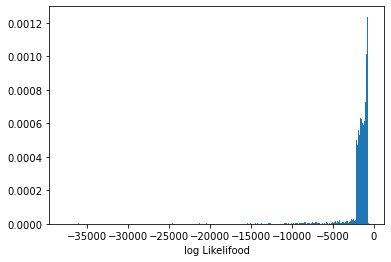

[0.2590148197036059, 0.23232232322323224, 0.2757927579275793]
0.001


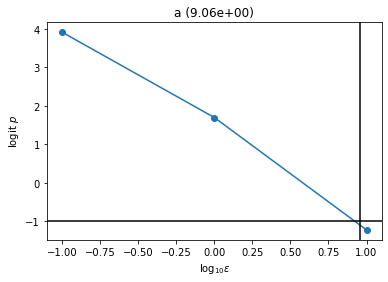

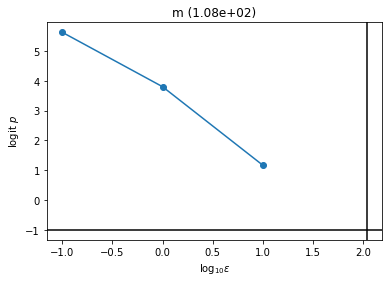

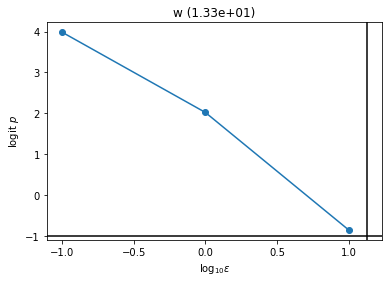

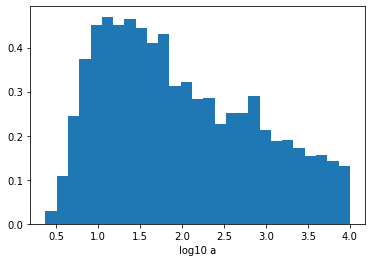

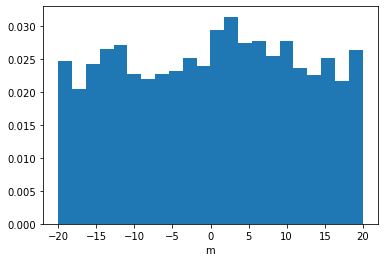

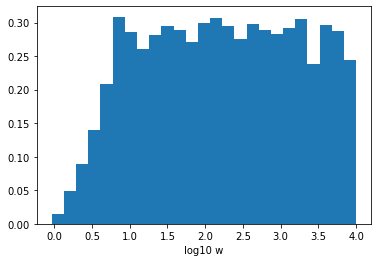

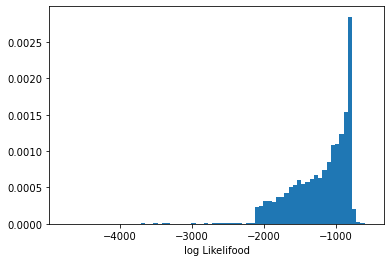

[0.25277494450111, 0.13695136951369513, 0.2201422014220142]
0.01


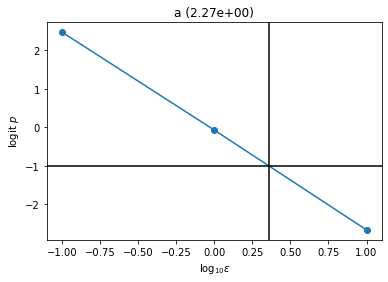

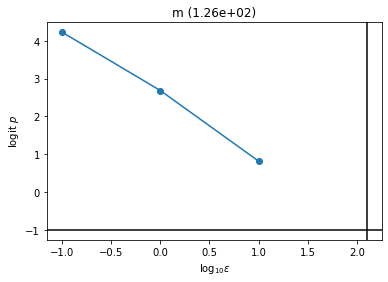

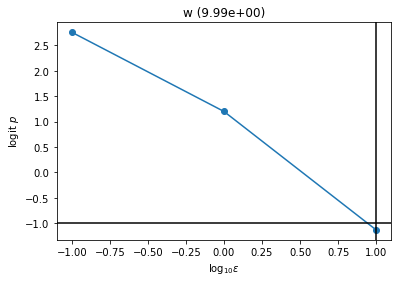

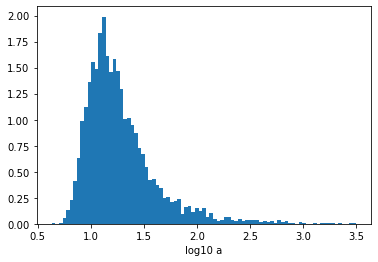

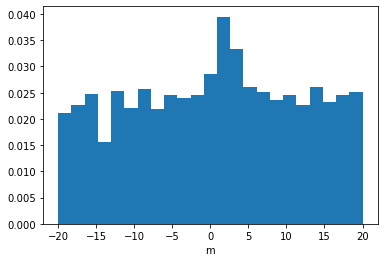

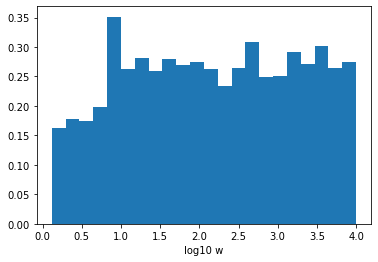

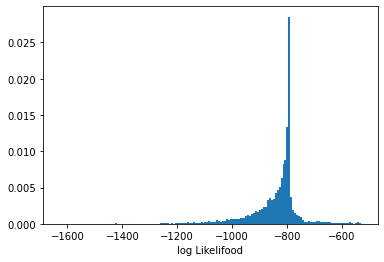

[0.252654946901062, 0.1040710407104071, 0.24231242312423124]
0.1


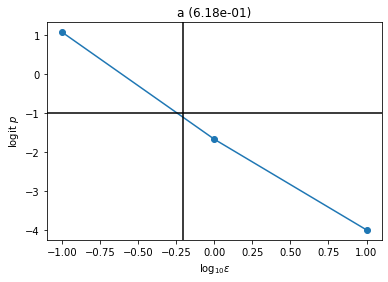

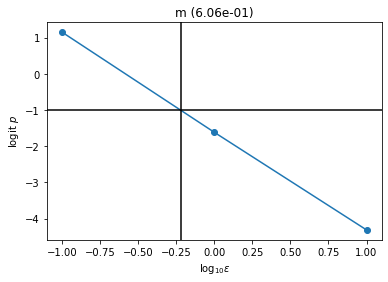

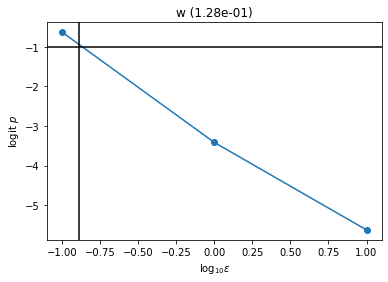

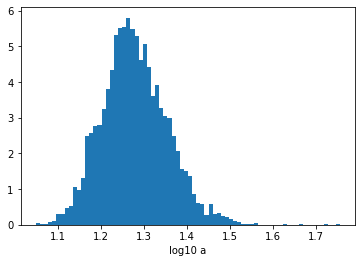

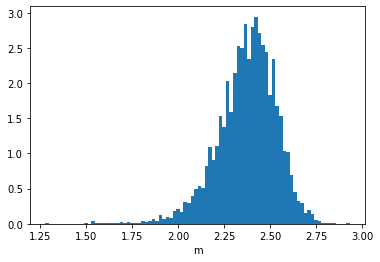

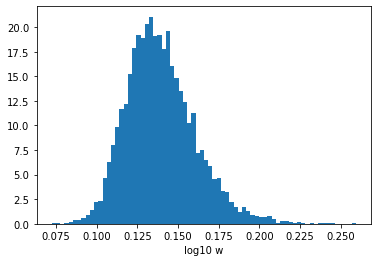

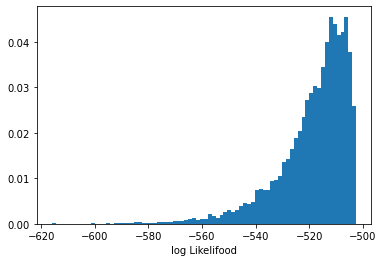

[0.24731505369892604, 0.2585725857258573, 0.2801128011280113]
1.0


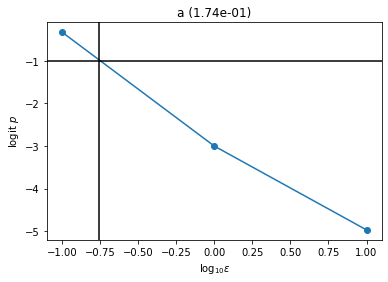

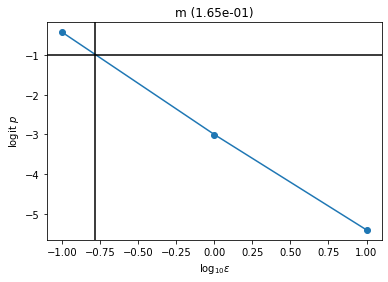

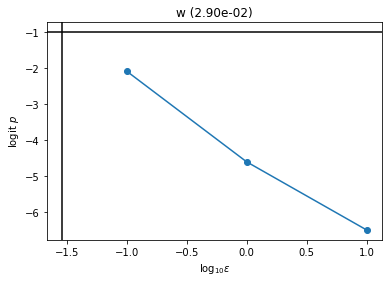

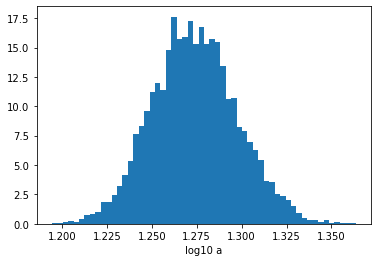

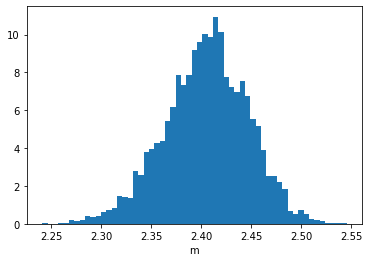

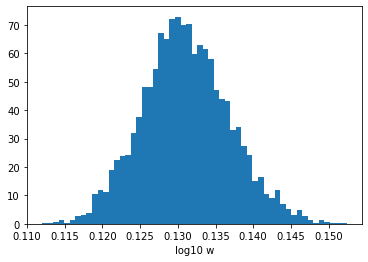

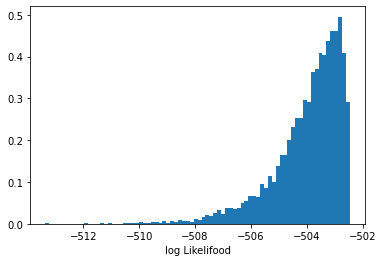

[0.2729645407091858, 0.26955269552695527, 0.3488734887348873]


In [174]:
*llss, = bayes_factor_g(X, Y)

(-372624936783794.06, 0.0)

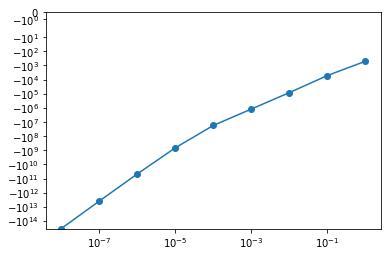

In [175]:
plt.plot(10**np.linspace(-8,0,9), llss/(10**np.linspace(-8,0,9)), marker='o')
plt.xscale('log')
plt.yscale('symlog')
plt.ylim(None,0)

In [176]:
betas = 10**np.linspace(-8, 0, 9)
(np.array(llss) * np.diff([0, *np.convolve(betas, [0.5,0.5], mode='valid'),1 ])).sum()

-532.8515889036877

In [196]:
import pickle
with open('gaussian_ll.bin', mode='wb') as f:
    pickle.dump(llss, f)

In [184]:
class MH_sampler_gaussian_sigma(object):
    def __init__(self, X, Y, eps=(0.1, 0.1, 0.1, 0.1), beta=1.0, random_state=None):
        self.eps = eps
        self.random_state = random_state
        self.random = np.random
        self.random.seed(random_state)
        self.X = X
        self.Y = Y
        self.beta = beta
    
    def logLikelihood(self, a, m, w, s):
        if not(1e-2<a<1e4 and -20<m<20 and 1e-2<w<1e4 and 1e-2<s<1e4):
            return -np.inf
        f = peek(self.X, a, m, w)
        return (-(self.Y - f)**2/2/s**2 - np.log(2*np.pi*s**2)/2).sum() * self.beta

    def sampling(self, samplesize=10**4, init=(1, 1, 1, 1)):
        pre_param = init
        samples = [pre_param]
        accepts = [False]
        pre_ll = self.logLikelihood(*pre_param)
        lls = [pre_ll]
        for i in range(1, samplesize):
            a,m,w,s = pre_param
            if i%4==0:
                la = np.log(a)
                la += self.random.normal(0, self.eps[0])
                a = np.exp(la)
            elif i%4==1:
                m += self.random.normal(0, self.eps[1])
            elif i%4==2:
                lw = np.log(w)
                lw += self.random.normal(0, self.eps[2])
                w = np.exp(lw)
            elif i%4==3:
                ls = np.log(s)
                ls += self.random.normal(0, self.eps[3])
                s = np.exp(ls)
            new_ll = self.logLikelihood(a, m, w, s)
            #print(a,m,w,new_ll)
            if new_ll>=pre_ll or self.random.rand() <= np.exp(-pre_ll+new_ll):
                accepts += [True]
                pre_param = (a, m, w, s)
                pre_ll = new_ll
            else:
                accepts += [False]
            samples += [pre_param]
            lls += [pre_ll]
        self.samples = np.array(samples)
        self.accepts = np.array(accepts)
        self.lls = np.array(lls)
        return self

In [186]:
def eps_adjust_logit_gs(X, Y, beta=1.0):
    epss = np.array([0.1,1,10])
    models = [MH_sampler_gaussian_sigma(X, Y, eps=(e,e,e,e), beta=beta).sampling(10**4, (34, 2.3, 1.2, 3.1))
             for e in epss]
    for i in range(4):
        logits = np.array(
            [logit(model.accepts[i::4].sum() / model.accepts[i::4].size)
             for model in models])
        a = ((np.log10(epss)*logits).mean()-np.log10(epss).mean()*logits.mean())\
            /((np.log10(epss)**2).mean()-np.log10(epss).mean()**2)
        b = logits.mean() - a*np.log10(epss).mean()
        r = (-1-b)/a
        plt.plot(np.log10(epss), logits, marker='o')
        plt.axhline(-1, color='k')
        plt.axvline(r, color='k')
        plt.title(f"{'amws'[i]} ({10**r:.2e})")
        #plt.ylim(0,1)
        plt.xlabel(r'$\log_{10}\varepsilon$')
        plt.ylabel(r'logit $p$')
        plt.show()
        yield 10**r

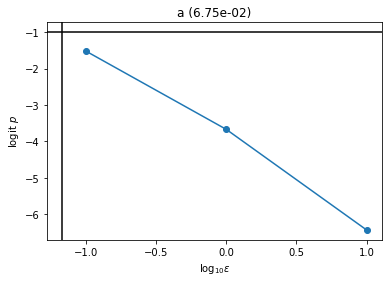

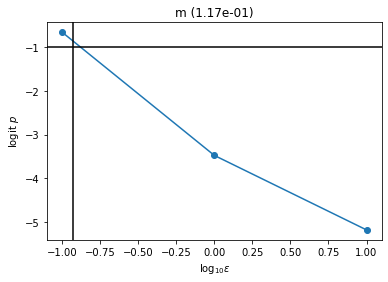

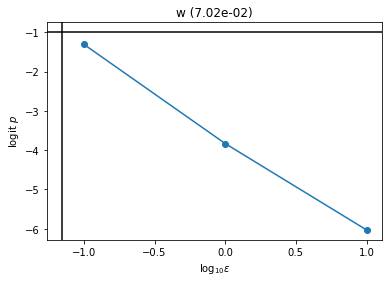

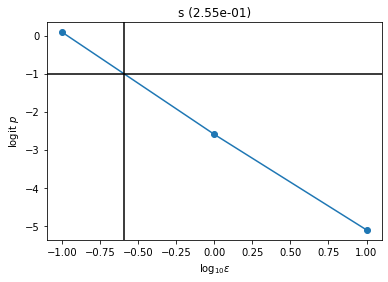

In [187]:
*epss,=eps_adjust_logit_gs(X, Y)

In [189]:
model = MH_sampler_gaussian_sigma(X, Y, eps=(*epss,), beta=1.0).sampling(10**5, (34, 2.3, 1.2, 3.1))

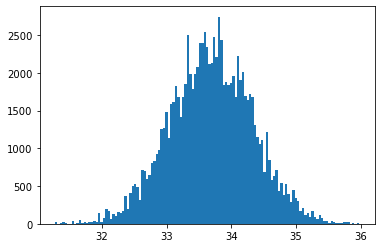

0.2692


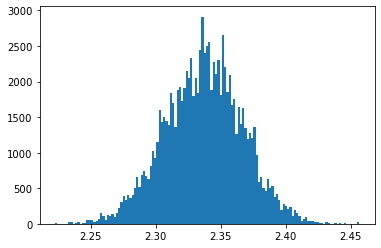

0.3036


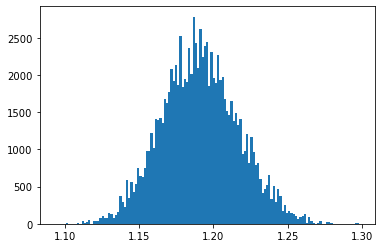

0.29572


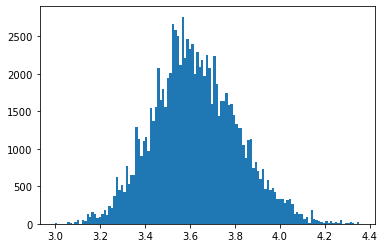

0.23372


In [193]:
for i in range(4):
    plt.hist(model.samples[:,i], bins='auto')
    plt.show()
    print(model.accepts[i::4].sum()/model.accepts[i::4].size)

In [203]:
def bayes_factor_gs(X, Y, betas=10**np.linspace(-8,0,9), sample_size=10**5):
    for beta in betas:
        print(beta)
        *epss, = eps_adjust_logit_gs(X, Y, beta)
        
        model = MH_sampler_gaussian_sigma(X, Y, eps=(*epss,), beta=beta)\
            .sampling(sample_size, (34, 2.3, 1.2, 3.1))
        plt.hist(np.log10(model.samples[sample_size//10::10,0]), bins='auto', density=True)
        plt.xlabel('log10 a')
        plt.show()
        plt.hist(model.samples[sample_size//10::10,1], bins='auto', density=True)
        plt.xlabel('m')
        plt.show()
        plt.hist(np.log10(model.samples[sample_size//10::10,2]), bins='auto', density=True)
        plt.xlabel('log10 w')
        plt.show()
        plt.hist(model.lls[sample_size//10::10]/beta, bins='auto', density=True)
        plt.xlabel('log Likelifood')
        plt.show()
        print([model.accepts[i::3].sum() / model.accepts[i::3].size
             for i in range(3)])
        
        yield (model.lls[sample_size//10::10]/beta).mean()

1e-08


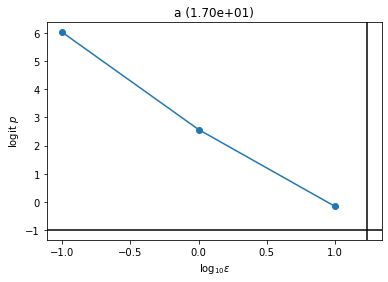

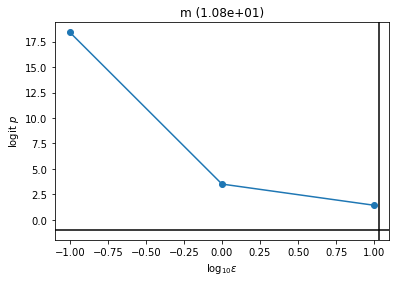

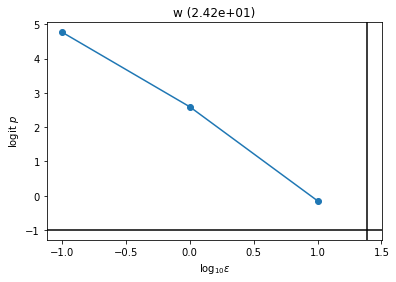

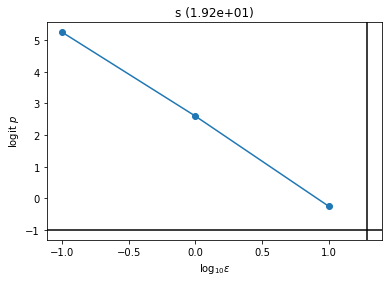

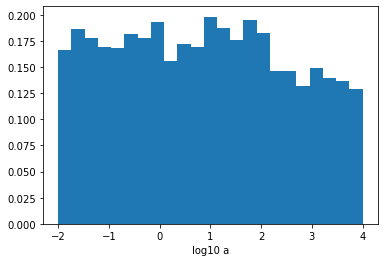

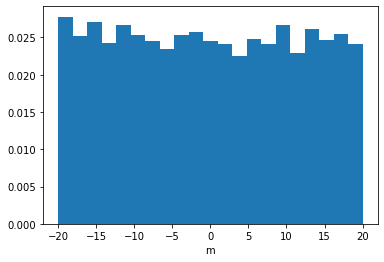

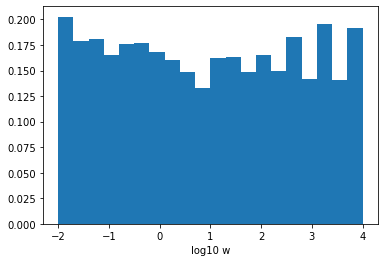

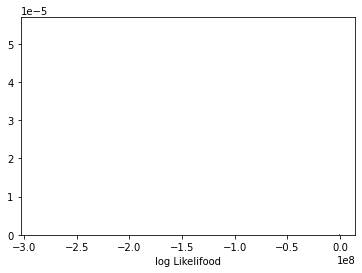

[0.37979240415191695, 0.38361383613836136, 0.3849338493384934]
1e-07


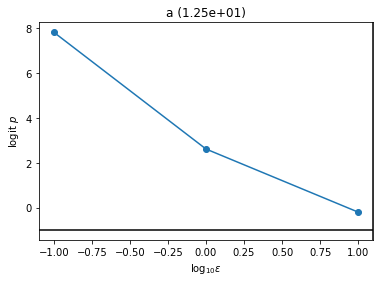

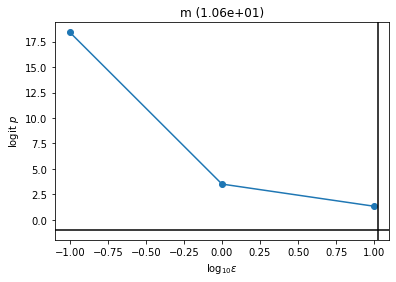

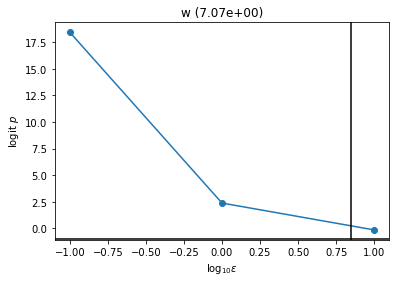

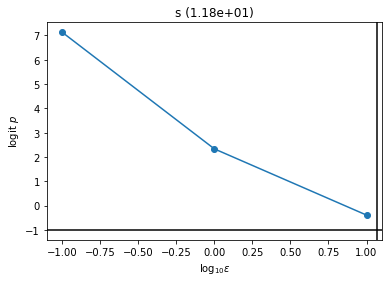

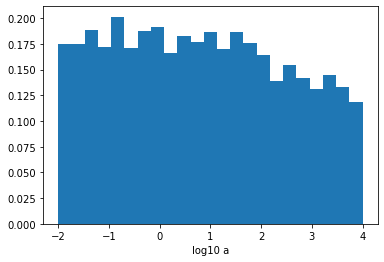

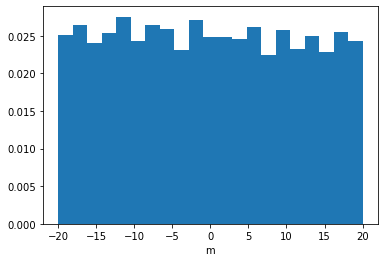

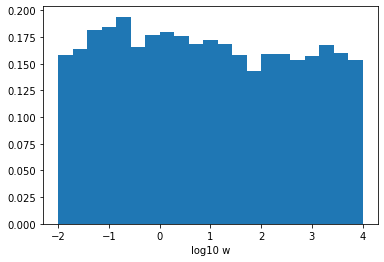

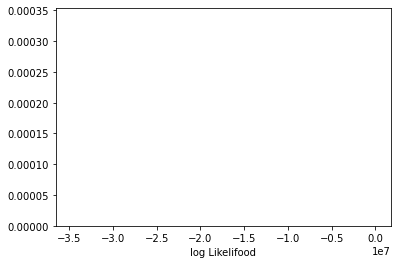

[0.5247495050098998, 0.5277652776527765, 0.5298952989529895]
1e-06


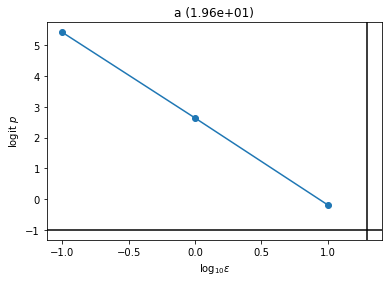

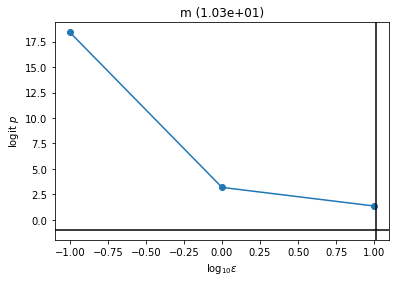

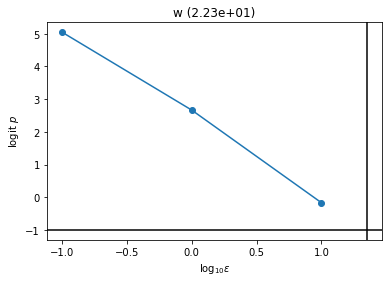

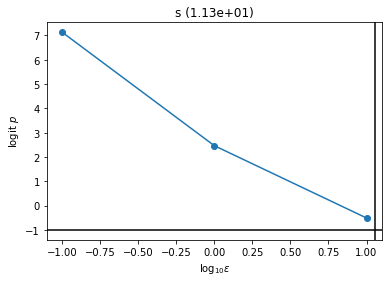

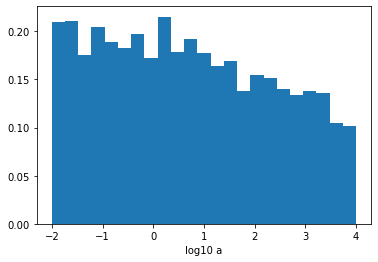

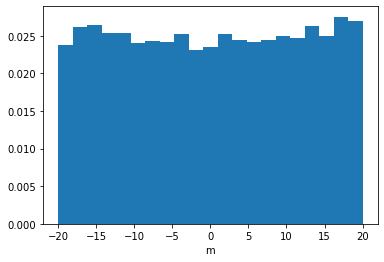

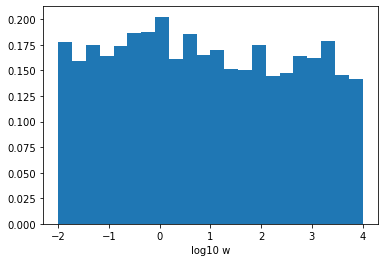

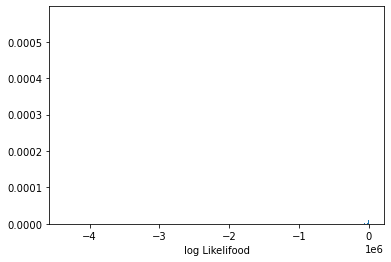

[0.4007619847603048, 0.4007140071400714, 0.3989739897398974]
1e-05


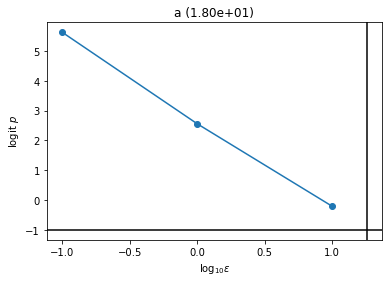

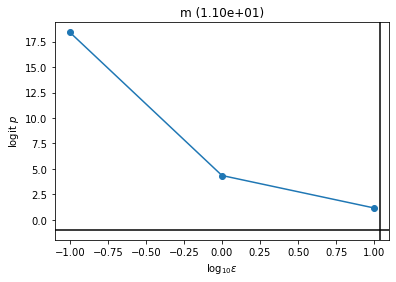

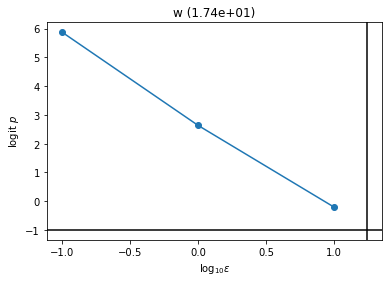

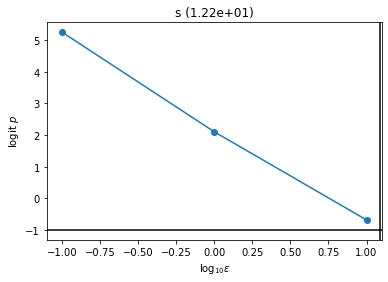

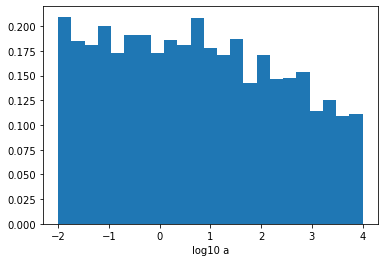

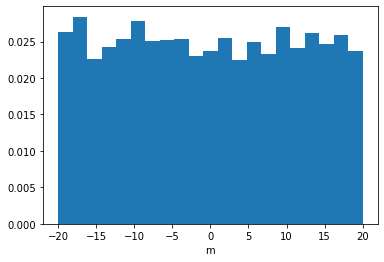

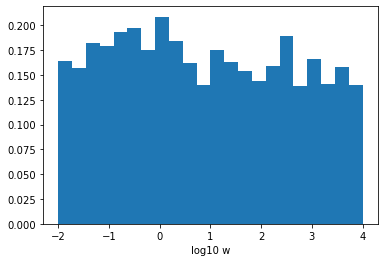

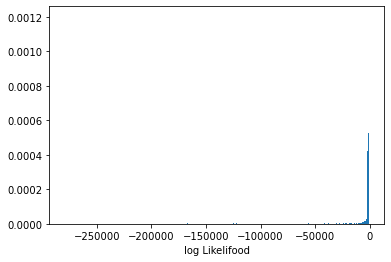

[0.3998920021599568, 0.4045240452404524, 0.4020640206402064]
0.0001


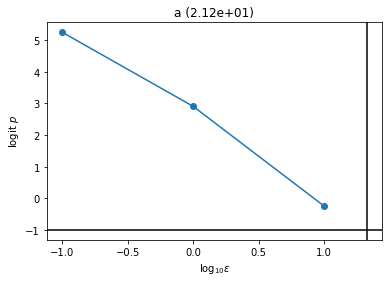

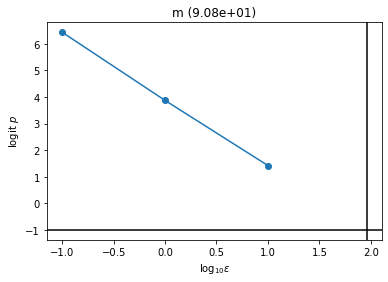

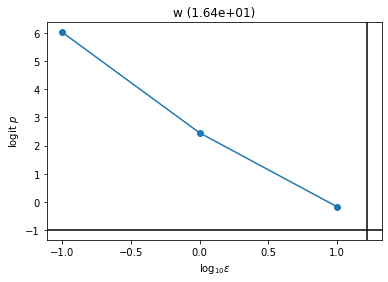

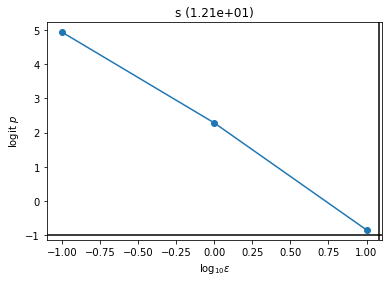

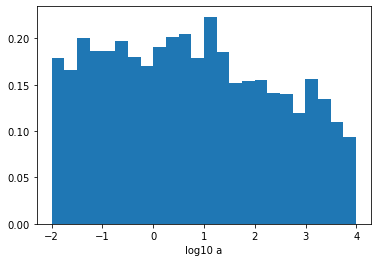

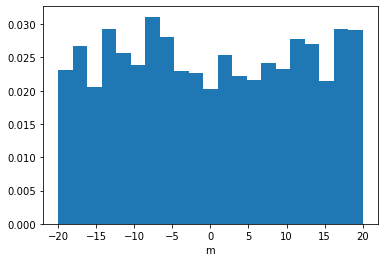

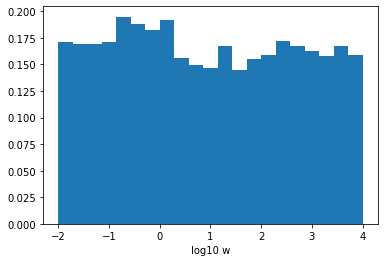

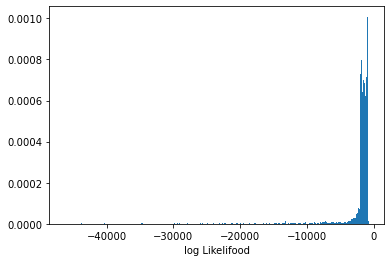

[0.23966520669586608, 0.23640236402364023, 0.24045240452404523]
0.001


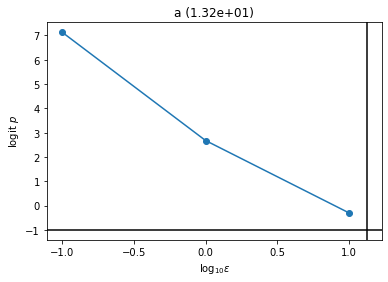

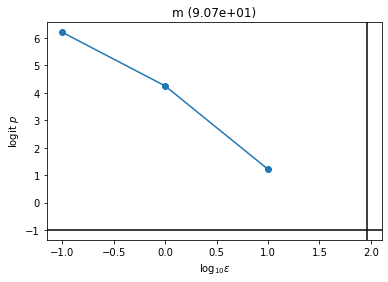

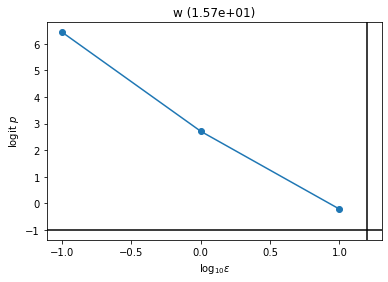

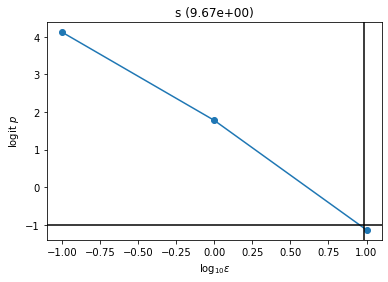

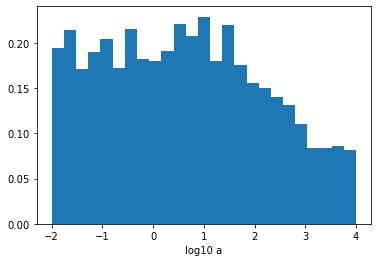

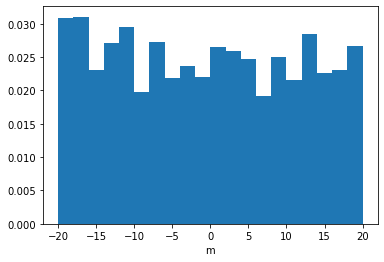

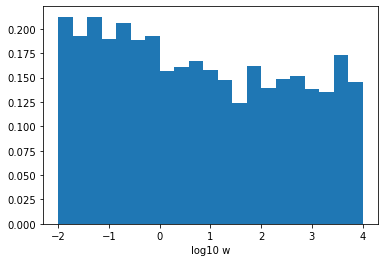

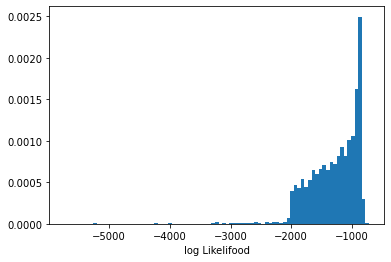

[0.2632147357052859, 0.2634026340263403, 0.26262262622626226]
0.01


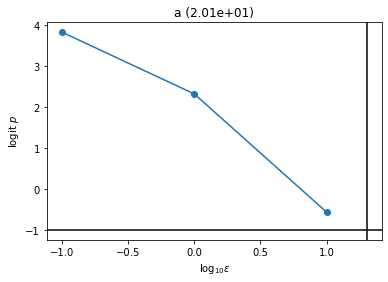

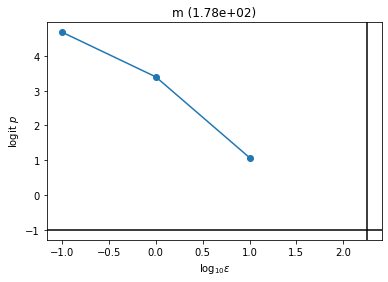

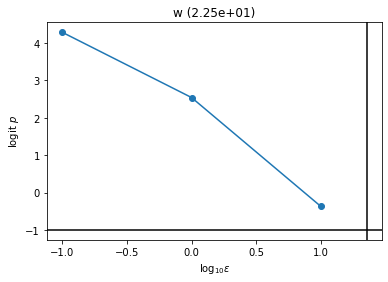

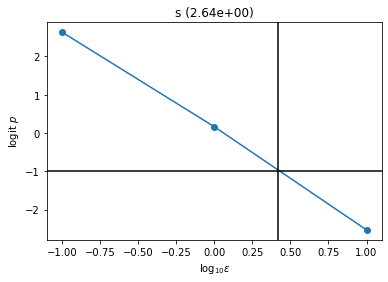

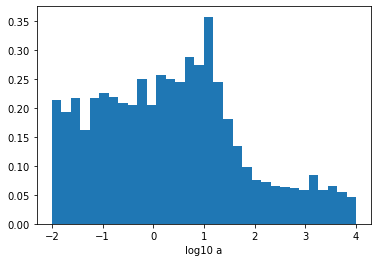

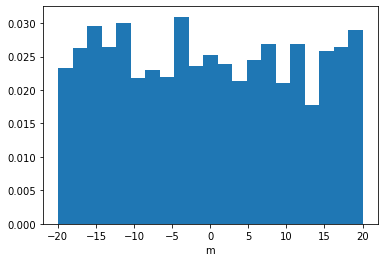

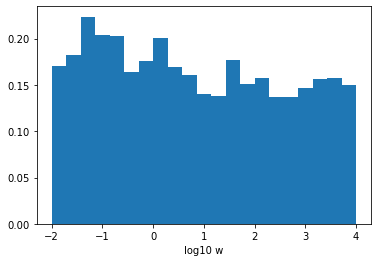

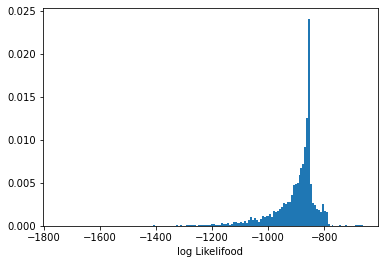

[0.1887862242755145, 0.18216182161821617, 0.1839018390183902]
0.1


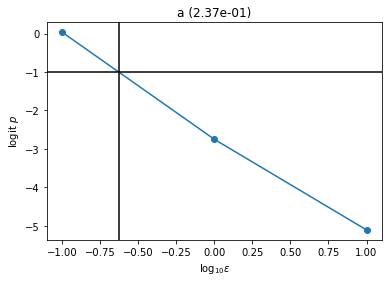

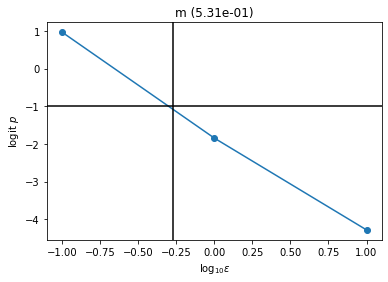

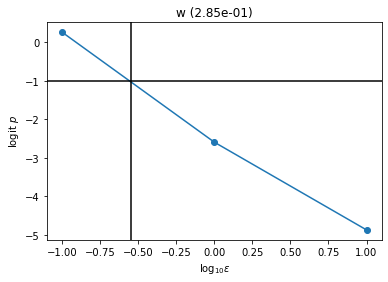

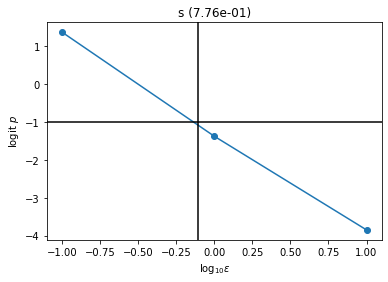

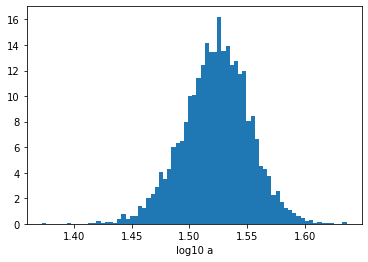

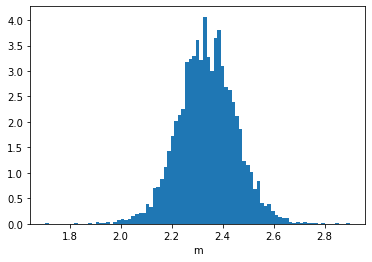

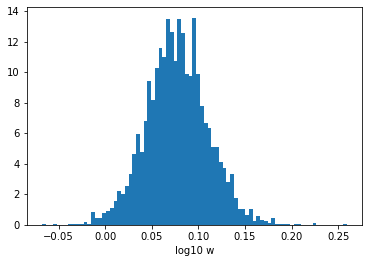

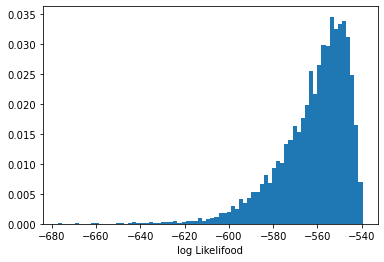

[0.2595848083038339, 0.25890258902589025, 0.25722257222572226]
1.0


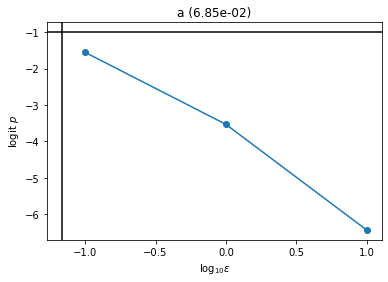

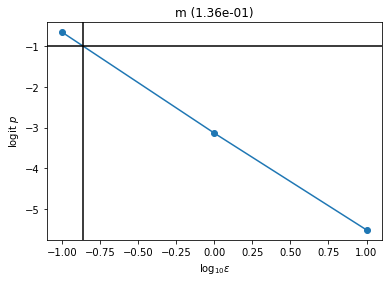

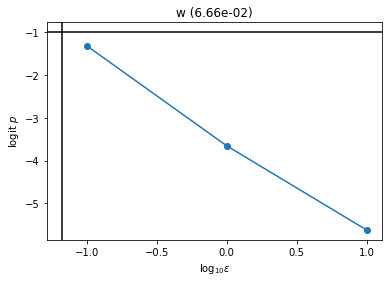

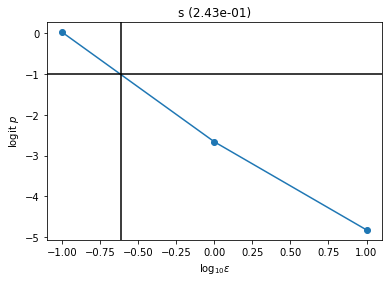

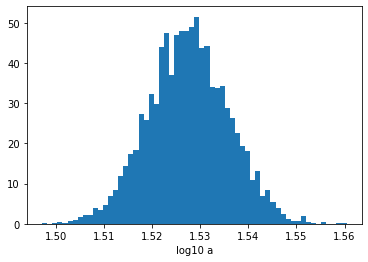

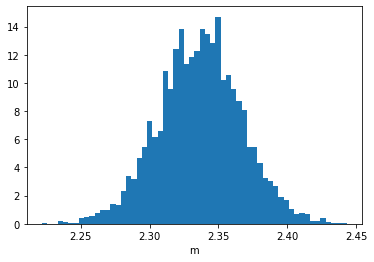

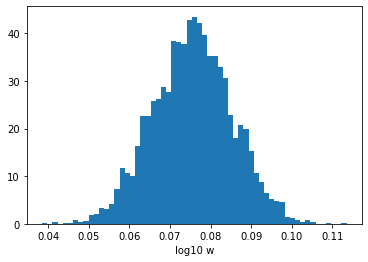

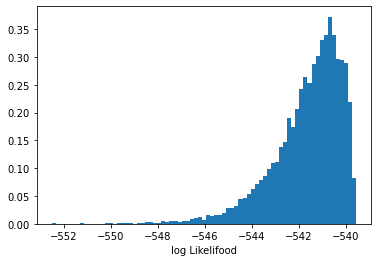

[0.27149457010859784, 0.2748327483274833, 0.27297272972729725]


In [204]:
*llss, = bayes_factor_gs(X, Y)

(-414634302926730.5, 0.0)

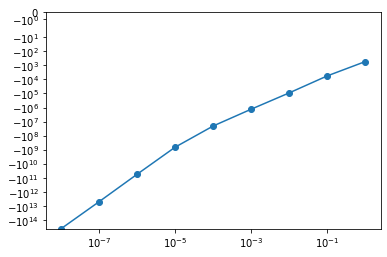

In [205]:
plt.plot(10**np.linspace(-8,0,9), llss/(10**np.linspace(-8,0,9)), marker='o')
plt.xscale('log')
plt.yscale('symlog')
plt.ylim(None,0)

In [206]:
betas = 10**np.linspace(-8, 0, 9)
(np.array(llss) * np.diff([0, *np.convolve(betas, [0.5,0.5], mode='valid'),1 ])).sum()

-574.9126861611769

In [207]:
import pickle
with open('gaussian_sigma_ll.bin', mode='wb') as f:
    pickle.dump(llss, f)